This is Japanese notebook.

# EfficientGAN 評価 - MVTecAD - 64x64

この試験評価は、

[書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)](https://www.amazon.co.jp/dp/4839970254/)

で実装されたサンプル「[第6章 GANによる異常検知（AnoGAN、Efficient GAN)](https://github.com/YutaroOgawa/pytorch_advanced/tree/master/6_gan_anomaly_detection)」を下記のように拡張したものです。

- データセットに[MVTecAD](https://www.mvtec.com/company/research/datasets/mvtec-ad/)を利用。
- その中からトランジスター画像を利用。
- 画像サイズは28x28、カラーのみ対応。

実行するには、下記を行ってください。

- /data/mvtecad/original/transistor を環境に合わせる。

In [1]:
from dlcliche.notebook import *
from dlcliche.utils import *
from dlcliche.math import *

import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms


def to_raw_image(img, denorm_tensor=True):
    if type(img) == torch.Tensor:
        # denormalize
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
        if denorm_tensor:
            img = (img * 0.5) + 0.5
        img = (img * 255).astype(np.uint8)
    return img

In [2]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generatorの実装



In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, # dl 3chへ変更
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out

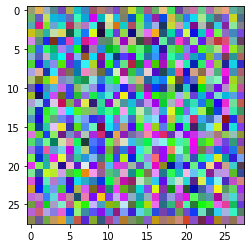

(28, 28, 3)


,count,mean,std,min,25%,50%,75%,max
0,2352.0,137.268707,74.128999,0.0,73.0,141.0,203.0,254.0


In [4]:
# 動作確認

G = Generator(z_dim=20)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = to_raw_image(fake_images[0].detach())
plt.imshow(img_transformed, 'gray')
plt.show()
print(img_transformed.shape)
np_describe(img_transformed)

# Discriminatorの実装

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, # dl カラー対応
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_outとz_outを結合し、全結合層で判定
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last2(out)

        return out, feature

In [6]:
# 動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.5270],
        [0.5392]], grad_fn=<SigmoidBackward>)


# Encoderの実装

画像をzに変換する

In [7]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, # dl カラー対応
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # ここまでで画像のサイズは7×7になっている
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out


In [8]:
# 動作確認
E = Encoder(z_dim=20)

# 入力する画像データ
x = fake_images  # fake_imagesは上のGで作成したもの

# 画像からzをEncode
z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-1.3273,  0.3747,  0.1045, -0.4716,  0.2531,  0.1067,  0.3245,  0.1754,
         -0.5869,  0.0872,  0.1586,  0.3850, -1.0881, -0.0812, -0.5736,  0.7344,
         -0.2851, -0.6786, -0.0111, -0.1836],
        [-0.1443, -0.2746, -0.2000, -0.0193,  0.2447,  0.5203, -0.5103,  0.4586,
         -0.7419,  0.5070,  0.0830, -0.4538, -0.0365,  0.7572,  0.3403,  0.4732,
         -0.0715,  0.4195,  0.6335, -0.1577]], grad_fn=<AddmmBackward>)


# DataLoaderの作成

In [9]:
# pix2pix実装から移植、データを予めロードサイズにリサイズしたコピーを作成し、高速化する

import numpy as np
from dlcliche.utils import Path, ensure_delete, ensure_folder
from PIL import Image


class TrainPrep(object):
    def __init__(self, project_name, train_files, load_size, crop_size, suffix,
                 pre_crop_rect=None, extra='', skip_file_creation=False):
        self.project, self.load_size, self.crop_size = project_name, load_size, crop_size
        self.suffix, self.pre_crop_rect, self.extra = suffix, pre_crop_rect, extra
        self.root = Path(f'./tmp/{self.project}')
        self.train = self.root/'train'
        self.test = self.root/'test'
        self.prepare_train(train_files, skip_file_creation)

    def copy_files_pre_crop(self, dest, files, skip_file_creation):
        new_filenames = []
        for f in files:
            file_name = str((dest/f'{f.parent.name}-{f.name}').with_suffix(self.suffix))
            assert file_name not in new_filenames
            if not skip_file_creation:
                img = Image.open(f).convert('RGB')
                if self.pre_crop_rect is not None:
                    img = img.crop(self.pre_crop_rect)
                img = img.resize((self.load_size, self.load_size))
                img.save(file_name)
            new_filenames.append(file_name)
        return new_filenames

    def prepare_train(self, train_files, skip_file_creation):
        if not skip_file_creation:
            ensure_delete(self.train)
            ensure_folder(self.train)
        self.train_files = self.copy_files_pre_crop(self.train, train_files, skip_file_creation)

    def prepare_test(self, test_files, skip_file_creation=False):
        if not skip_file_creation:
            ensure_delete(self.test)
            ensure_folder(self.test)
        self.test_files = self.copy_files_pre_crop(self.test, test_files, skip_file_creation=skip_file_creation)

In [10]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_ROOT.glob(f'train/good/*{SUFFIX}'))

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [11]:
def random_crop(opt, pil_img):
    w, h = pil_img.size
    if opt.random:
        x = random.randint(0, np.maximum(0, w - opt.crop_size))
        y = random.randint(0, np.maximum(0, h - opt.crop_size))
    else:
        x = (w - opt.crop_size) // 2
        y = (h - opt.crop_size) // 2
    return pil_img.crop((x, y, x+opt.crop_size, y+opt.crop_size))

class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, load_size, crop_size, transform, random, debug=None):
        self.file_list = file_list
        self.load_size, self.crop_size = load_size, crop_size
        self.transform, self.random, self.debug = transform, random, debug

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        if self.debug is not None: print(f'{self.debug}[{index}]')

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色] # dl カラー対応
        img = img.resize((self.load_size, self.load_size))
        img = random_crop(self, img)

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

In [12]:
# DataLoaderの作成と動作確認

DATA_ROOT = Path('/data/mvtec_ad/original/transistor')
SUFFIX = '.png'
SIZE = 28
batch_size = 64

# ファイルリストを作成
train_img_list=make_datapath_list()

# リサイズして準備
prep = TrainPrep('effgan-mvtrans', train_img_list, load_size=SIZE+4, crop_size=SIZE, suffix=SUFFIX,
                skip_file_creation=True
                )

# Datasetを作成
train_dataset = GAN_Img_Dataset(file_list=prep.train_files, load_size=SIZE + 4, crop_size=SIZE, transform=ImageTransform(), random=True)

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 3, 64, 64])  # dl カラー対応

torch.Size([64, 3, 28, 28])


# 学習させる

In [13]:
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# モデルを学習させる関数を作成

def train_model(G, D, E, dataloader, num_epochs):

    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('Epoch {}/{}'.format(epoch, num_epochs))

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像を判定　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E

使用デバイス： cuda:0


In [14]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [15]:
%%time
# 学習・検証を実行する x分ほどかかる

num_epochs = 10000
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Epoch 0/10000
epoch 0 || Epoch_D_Loss:0.0876 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0436
timer:  0.1883 sec.
Epoch 1/10000
epoch 1 || Epoch_D_Loss:0.0864 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0441
timer:  0.1002 sec.
Epoch 2/10000
epoch 2 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0447
timer:  0.0985 sec.
Epoch 3/10000
epoch 3 || Epoch_D_Loss:0.0837 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0454
timer:  0.0972 sec.
Epoch 4/10000
epoch 4 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0464
timer:  0.0992 sec.
Epoch 5/10000
epoch 5 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.0456 ||Epoch_E_Loss:0.0473
timer:  0.0964 sec.
Epoch 6/10000
epoch 6 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0461 ||Epoch_E_Loss:0.0481
timer:  0.0963 sec.
Epoch 7/10000
epoch 7 || Epoch_D_Loss:0.0789 ||Epoch_G_Loss:0.0467 ||Epoch_E_Loss:0.0489
timer:  0.0966 sec.
Epoch 8/10000
epoch 8 || Epoch_D_Loss:0.0780 ||Epoch_G_Loss:0.04

epoch 76 || Epoch_D_Loss:0.0181 ||Epoch_G_Loss:0.1389 ||Epoch_E_Loss:0.1460
timer:  0.0964 sec.
Epoch 77/10000
epoch 77 || Epoch_D_Loss:0.0211 ||Epoch_G_Loss:0.1361 ||Epoch_E_Loss:0.1331
timer:  0.0963 sec.
Epoch 78/10000
epoch 78 || Epoch_D_Loss:0.0258 ||Epoch_G_Loss:0.1315 ||Epoch_E_Loss:0.1216
timer:  0.0965 sec.
Epoch 79/10000
epoch 79 || Epoch_D_Loss:0.0199 ||Epoch_G_Loss:0.1397 ||Epoch_E_Loss:0.1385
timer:  0.0966 sec.
Epoch 80/10000
epoch 80 || Epoch_D_Loss:0.0165 ||Epoch_G_Loss:0.1462 ||Epoch_E_Loss:0.1513
timer:  0.0964 sec.
Epoch 81/10000
epoch 81 || Epoch_D_Loss:0.0154 ||Epoch_G_Loss:0.1486 ||Epoch_E_Loss:0.1582
timer:  0.0962 sec.
Epoch 82/10000
epoch 82 || Epoch_D_Loss:0.0142 ||Epoch_G_Loss:0.1503 ||Epoch_E_Loss:0.1619
timer:  0.0966 sec.
Epoch 83/10000
epoch 83 || Epoch_D_Loss:0.0148 ||Epoch_G_Loss:0.1514 ||Epoch_E_Loss:0.1569
timer:  0.0965 sec.
Epoch 84/10000
epoch 84 || Epoch_D_Loss:0.0180 ||Epoch_G_Loss:0.1485 ||Epoch_E_Loss:0.1418
timer:  0.0962 sec.
Epoch 85/10000
e

epoch 151 || Epoch_D_Loss:0.0370 ||Epoch_G_Loss:0.1166 ||Epoch_E_Loss:0.1148
timer:  0.0959 sec.
Epoch 152/10000
epoch 152 || Epoch_D_Loss:0.0386 ||Epoch_G_Loss:0.1064 ||Epoch_E_Loss:0.1125
timer:  0.0957 sec.
Epoch 153/10000
epoch 153 || Epoch_D_Loss:0.0388 ||Epoch_G_Loss:0.1047 ||Epoch_E_Loss:0.1085
timer:  0.0956 sec.
Epoch 154/10000
epoch 154 || Epoch_D_Loss:0.0387 ||Epoch_G_Loss:0.1026 ||Epoch_E_Loss:0.1083
timer:  0.0959 sec.
Epoch 155/10000
epoch 155 || Epoch_D_Loss:0.0419 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1045
timer:  0.0956 sec.
Epoch 156/10000
epoch 156 || Epoch_D_Loss:0.0437 ||Epoch_G_Loss:0.1001 ||Epoch_E_Loss:0.1005
timer:  0.0955 sec.
Epoch 157/10000
epoch 157 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.0961 ||Epoch_E_Loss:0.1004
timer:  0.0961 sec.
Epoch 158/10000
epoch 158 || Epoch_D_Loss:0.0455 ||Epoch_G_Loss:0.0883 ||Epoch_E_Loss:0.1020
timer:  0.0958 sec.
Epoch 159/10000
epoch 159 || Epoch_D_Loss:0.0390 ||Epoch_G_Loss:0.1181 ||Epoch_E_Loss:0.1054
timer:  0.0955 sec.

epoch 226 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0769 ||Epoch_E_Loss:0.0811
timer:  0.0950 sec.
Epoch 227/10000
epoch 227 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0730 ||Epoch_E_Loss:0.0765
timer:  0.0947 sec.
Epoch 228/10000
epoch 228 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0726
timer:  0.0947 sec.
Epoch 229/10000
epoch 229 || Epoch_D_Loss:0.0828 ||Epoch_G_Loss:0.0483 ||Epoch_E_Loss:0.0658
timer:  0.0949 sec.
Epoch 230/10000
epoch 230 || Epoch_D_Loss:0.0866 ||Epoch_G_Loss:0.0504 ||Epoch_E_Loss:0.0647
timer:  0.0947 sec.
Epoch 231/10000
epoch 231 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.0539 ||Epoch_E_Loss:0.0607
timer:  0.0946 sec.
Epoch 232/10000
epoch 232 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0524 ||Epoch_E_Loss:0.0698
timer:  0.0948 sec.
Epoch 233/10000
epoch 233 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0687
timer:  0.0949 sec.
Epoch 234/10000
epoch 234 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0736
timer:  0.0947 sec.

epoch 301 || Epoch_D_Loss:0.0858 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0614
timer:  0.0952 sec.
Epoch 302/10000
epoch 302 || Epoch_D_Loss:0.0868 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0598
timer:  0.0948 sec.
Epoch 303/10000
epoch 303 || Epoch_D_Loss:0.0910 ||Epoch_G_Loss:0.0491 ||Epoch_E_Loss:0.0574
timer:  0.0949 sec.
Epoch 304/10000
epoch 304 || Epoch_D_Loss:0.0898 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0564
timer:  0.0954 sec.
Epoch 305/10000
epoch 305 || Epoch_D_Loss:0.0991 ||Epoch_G_Loss:0.0421 ||Epoch_E_Loss:0.0534
timer:  0.0949 sec.
Epoch 306/10000
epoch 306 || Epoch_D_Loss:0.1042 ||Epoch_G_Loss:0.0391 ||Epoch_E_Loss:0.0530
timer:  0.0951 sec.
Epoch 307/10000
epoch 307 || Epoch_D_Loss:0.1040 ||Epoch_G_Loss:0.0415 ||Epoch_E_Loss:0.0522
timer:  0.0952 sec.
Epoch 308/10000
epoch 308 || Epoch_D_Loss:0.0912 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0580
timer:  0.0949 sec.
Epoch 309/10000
epoch 309 || Epoch_D_Loss:0.0914 ||Epoch_G_Loss:0.0466 ||Epoch_E_Loss:0.0581
timer:  0.0948 sec.

epoch 376 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0467 ||Epoch_E_Loss:0.0615
timer:  0.0952 sec.
Epoch 377/10000
epoch 377 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0664
timer:  0.0950 sec.
Epoch 378/10000
epoch 378 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0692
timer:  0.0951 sec.
Epoch 379/10000
epoch 379 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0716
timer:  0.0952 sec.
Epoch 380/10000
epoch 380 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0734
timer:  0.0949 sec.
Epoch 381/10000
epoch 381 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0680
timer:  0.0949 sec.
Epoch 382/10000
epoch 382 || Epoch_D_Loss:0.0818 ||Epoch_G_Loss:0.0527 ||Epoch_E_Loss:0.0593
timer:  0.0951 sec.
Epoch 383/10000
epoch 383 || Epoch_D_Loss:0.0962 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0526
timer:  0.0951 sec.
Epoch 384/10000
epoch 384 || Epoch_D_Loss:0.0963 ||Epoch_G_Loss:0.0428 ||Epoch_E_Loss:0.0524
timer:  0.0951 sec.

epoch 451 || Epoch_D_Loss:0.1091 ||Epoch_G_Loss:0.0354 ||Epoch_E_Loss:0.0436
timer:  0.0951 sec.
Epoch 452/10000
epoch 452 || Epoch_D_Loss:0.1186 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0418
timer:  0.0950 sec.
Epoch 453/10000
epoch 453 || Epoch_D_Loss:0.1082 ||Epoch_G_Loss:0.0343 ||Epoch_E_Loss:0.0438
timer:  0.0949 sec.
Epoch 454/10000
epoch 454 || Epoch_D_Loss:0.1120 ||Epoch_G_Loss:0.0374 ||Epoch_E_Loss:0.0444
timer:  0.0951 sec.
Epoch 455/10000
epoch 455 || Epoch_D_Loss:0.1090 ||Epoch_G_Loss:0.0403 ||Epoch_E_Loss:0.0443
timer:  0.0949 sec.
Epoch 456/10000
epoch 456 || Epoch_D_Loss:0.1045 ||Epoch_G_Loss:0.0377 ||Epoch_E_Loss:0.0451
timer:  0.0948 sec.
Epoch 457/10000
epoch 457 || Epoch_D_Loss:0.1057 ||Epoch_G_Loss:0.0385 ||Epoch_E_Loss:0.0460
timer:  0.0950 sec.
Epoch 458/10000
epoch 458 || Epoch_D_Loss:0.1057 ||Epoch_G_Loss:0.0380 ||Epoch_E_Loss:0.0441
timer:  0.0957 sec.
Epoch 459/10000
epoch 459 || Epoch_D_Loss:0.1083 ||Epoch_G_Loss:0.0341 ||Epoch_E_Loss:0.0455
timer:  0.0948 sec.

epoch 526 || Epoch_D_Loss:0.1096 ||Epoch_G_Loss:0.0356 ||Epoch_E_Loss:0.0414
timer:  0.0954 sec.
Epoch 527/10000
epoch 527 || Epoch_D_Loss:0.1127 ||Epoch_G_Loss:0.0367 ||Epoch_E_Loss:0.0405
timer:  0.0948 sec.
Epoch 528/10000
epoch 528 || Epoch_D_Loss:0.1056 ||Epoch_G_Loss:0.0370 ||Epoch_E_Loss:0.0427
timer:  0.0949 sec.
Epoch 529/10000
epoch 529 || Epoch_D_Loss:0.1002 ||Epoch_G_Loss:0.0363 ||Epoch_E_Loss:0.0438
timer:  0.0958 sec.
Epoch 530/10000
epoch 530 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.0383 ||Epoch_E_Loss:0.0447
timer:  0.0952 sec.
Epoch 531/10000
epoch 531 || Epoch_D_Loss:0.0989 ||Epoch_G_Loss:0.0364 ||Epoch_E_Loss:0.0457
timer:  0.0948 sec.
Epoch 532/10000
epoch 532 || Epoch_D_Loss:0.1057 ||Epoch_G_Loss:0.0388 ||Epoch_E_Loss:0.0442
timer:  0.0953 sec.
Epoch 533/10000
epoch 533 || Epoch_D_Loss:0.1040 ||Epoch_G_Loss:0.0390 ||Epoch_E_Loss:0.0433
timer:  0.0950 sec.
Epoch 534/10000
epoch 534 || Epoch_D_Loss:0.1046 ||Epoch_G_Loss:0.0372 ||Epoch_E_Loss:0.0431
timer:  0.0950 sec.

epoch 601 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.0385 ||Epoch_E_Loss:0.0452
timer:  0.0957 sec.
Epoch 602/10000
epoch 602 || Epoch_D_Loss:0.0925 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0453
timer:  0.0948 sec.
Epoch 603/10000
epoch 603 || Epoch_D_Loss:0.0923 ||Epoch_G_Loss:0.0407 ||Epoch_E_Loss:0.0456
timer:  0.0947 sec.
Epoch 604/10000
epoch 604 || Epoch_D_Loss:0.0945 ||Epoch_G_Loss:0.0410 ||Epoch_E_Loss:0.0467
timer:  0.0955 sec.
Epoch 605/10000
epoch 605 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.0428 ||Epoch_E_Loss:0.0473
timer:  0.0949 sec.
Epoch 606/10000
epoch 606 || Epoch_D_Loss:0.0903 ||Epoch_G_Loss:0.0429 ||Epoch_E_Loss:0.0487
timer:  0.0949 sec.
Epoch 607/10000
epoch 607 || Epoch_D_Loss:0.0866 ||Epoch_G_Loss:0.0443 ||Epoch_E_Loss:0.0497
timer:  0.0955 sec.
Epoch 608/10000
epoch 608 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0504
timer:  0.0951 sec.
Epoch 609/10000
epoch 609 || Epoch_D_Loss:0.0883 ||Epoch_G_Loss:0.0437 ||Epoch_E_Loss:0.0489
timer:  0.0950 sec.

epoch 676 || Epoch_D_Loss:0.1069 ||Epoch_G_Loss:0.0368 ||Epoch_E_Loss:0.0387
timer:  0.0955 sec.
Epoch 677/10000
epoch 677 || Epoch_D_Loss:0.1033 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0399
timer:  0.0947 sec.
Epoch 678/10000
epoch 678 || Epoch_D_Loss:0.0970 ||Epoch_G_Loss:0.0404 ||Epoch_E_Loss:0.0426
timer:  0.0953 sec.
Epoch 679/10000
epoch 679 || Epoch_D_Loss:0.0920 ||Epoch_G_Loss:0.0413 ||Epoch_E_Loss:0.0453
timer:  0.0952 sec.
Epoch 680/10000
epoch 680 || Epoch_D_Loss:0.0888 ||Epoch_G_Loss:0.0427 ||Epoch_E_Loss:0.0466
timer:  0.0950 sec.
Epoch 681/10000
epoch 681 || Epoch_D_Loss:0.0849 ||Epoch_G_Loss:0.0454 ||Epoch_E_Loss:0.0484
timer:  0.0950 sec.
Epoch 682/10000
epoch 682 || Epoch_D_Loss:0.0835 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0501
timer:  0.0954 sec.
Epoch 683/10000
epoch 683 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0471 ||Epoch_E_Loss:0.0495
timer:  0.0951 sec.
Epoch 684/10000
epoch 684 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0502
timer:  0.0951 sec.

epoch 751 || Epoch_D_Loss:0.0936 ||Epoch_G_Loss:0.0411 ||Epoch_E_Loss:0.0444
timer:  0.0951 sec.
Epoch 752/10000
epoch 752 || Epoch_D_Loss:0.0953 ||Epoch_G_Loss:0.0425 ||Epoch_E_Loss:0.0436
timer:  0.0949 sec.
Epoch 753/10000
epoch 753 || Epoch_D_Loss:0.0927 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0447
timer:  0.0949 sec.
Epoch 754/10000
epoch 754 || Epoch_D_Loss:0.0922 ||Epoch_G_Loss:0.0441 ||Epoch_E_Loss:0.0463
timer:  0.0951 sec.
Epoch 755/10000
epoch 755 || Epoch_D_Loss:0.0855 ||Epoch_G_Loss:0.0450 ||Epoch_E_Loss:0.0483
timer:  0.0948 sec.
Epoch 756/10000
epoch 756 || Epoch_D_Loss:0.0824 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0503
timer:  0.0948 sec.
Epoch 757/10000
epoch 757 || Epoch_D_Loss:0.0823 ||Epoch_G_Loss:0.0468 ||Epoch_E_Loss:0.0510
timer:  0.0953 sec.
Epoch 758/10000
epoch 758 || Epoch_D_Loss:0.0818 ||Epoch_G_Loss:0.0462 ||Epoch_E_Loss:0.0503
timer:  0.0951 sec.
Epoch 759/10000
epoch 759 || Epoch_D_Loss:0.0870 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0483
timer:  0.0948 sec.

epoch 826 || Epoch_D_Loss:0.0919 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0434
timer:  0.0950 sec.
Epoch 827/10000
epoch 827 || Epoch_D_Loss:0.0919 ||Epoch_G_Loss:0.0410 ||Epoch_E_Loss:0.0439
timer:  0.0947 sec.
Epoch 828/10000
epoch 828 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.0409 ||Epoch_E_Loss:0.0429
timer:  0.0947 sec.
Epoch 829/10000
epoch 829 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.0411 ||Epoch_E_Loss:0.0429
timer:  0.0951 sec.
Epoch 830/10000
epoch 830 || Epoch_D_Loss:0.0920 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0437
timer:  0.0948 sec.
Epoch 831/10000
epoch 831 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.0417 ||Epoch_E_Loss:0.0442
timer:  0.0950 sec.
Epoch 832/10000
epoch 832 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.0410 ||Epoch_E_Loss:0.0454
timer:  0.0955 sec.
Epoch 833/10000
epoch 833 || Epoch_D_Loss:0.0888 ||Epoch_G_Loss:0.0453 ||Epoch_E_Loss:0.0448
timer:  0.0952 sec.
Epoch 834/10000
epoch 834 || Epoch_D_Loss:0.0855 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0464
timer:  0.0951 sec.

epoch 901 || Epoch_D_Loss:0.0924 ||Epoch_G_Loss:0.0430 ||Epoch_E_Loss:0.0417
timer:  0.0978 sec.
Epoch 902/10000
epoch 902 || Epoch_D_Loss:0.0919 ||Epoch_G_Loss:0.0419 ||Epoch_E_Loss:0.0426
timer:  0.0972 sec.
Epoch 903/10000
epoch 903 || Epoch_D_Loss:0.0900 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0431
timer:  0.0977 sec.
Epoch 904/10000
epoch 904 || Epoch_D_Loss:0.0884 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0445
timer:  0.0978 sec.
Epoch 905/10000
epoch 905 || Epoch_D_Loss:0.0879 ||Epoch_G_Loss:0.0431 ||Epoch_E_Loss:0.0445
timer:  0.0978 sec.
Epoch 906/10000
epoch 906 || Epoch_D_Loss:0.0857 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0457
timer:  0.0974 sec.
Epoch 907/10000
epoch 907 || Epoch_D_Loss:0.0840 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0467
timer:  0.0982 sec.
Epoch 908/10000
epoch 908 || Epoch_D_Loss:0.0846 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0465
timer:  0.0974 sec.
Epoch 909/10000
epoch 909 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0469
timer:  0.0973 sec.

epoch 976 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0480
timer:  0.0953 sec.
Epoch 977/10000
epoch 977 || Epoch_D_Loss:0.0848 ||Epoch_G_Loss:0.0460 ||Epoch_E_Loss:0.0470
timer:  0.0950 sec.
Epoch 978/10000
epoch 978 || Epoch_D_Loss:0.0850 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0461
timer:  0.0952 sec.
Epoch 979/10000
epoch 979 || Epoch_D_Loss:0.0879 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0460
timer:  0.0954 sec.
Epoch 980/10000
epoch 980 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0453
timer:  0.0951 sec.
Epoch 981/10000
epoch 981 || Epoch_D_Loss:0.0890 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0451
timer:  0.0948 sec.
Epoch 982/10000
epoch 982 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0436
timer:  0.0955 sec.
Epoch 983/10000
epoch 983 || Epoch_D_Loss:0.0910 ||Epoch_G_Loss:0.0411 ||Epoch_E_Loss:0.0434
timer:  0.0949 sec.
Epoch 984/10000
epoch 984 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.0405 ||Epoch_E_Loss:0.0426
timer:  0.0951 sec.

epoch 1048 || Epoch_D_Loss:0.0884 ||Epoch_G_Loss:0.0430 ||Epoch_E_Loss:0.0444
timer:  0.0956 sec.
Epoch 1049/10000
epoch 1049 || Epoch_D_Loss:0.0901 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0443
timer:  0.0950 sec.
Epoch 1050/10000
epoch 1050 || Epoch_D_Loss:0.0878 ||Epoch_G_Loss:0.0431 ||Epoch_E_Loss:0.0450
timer:  0.0950 sec.
Epoch 1051/10000
epoch 1051 || Epoch_D_Loss:0.0879 ||Epoch_G_Loss:0.0443 ||Epoch_E_Loss:0.0450
timer:  0.0957 sec.
Epoch 1052/10000
epoch 1052 || Epoch_D_Loss:0.0896 ||Epoch_G_Loss:0.0435 ||Epoch_E_Loss:0.0440
timer:  0.0950 sec.
Epoch 1053/10000
epoch 1053 || Epoch_D_Loss:0.0901 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0440
timer:  0.0951 sec.
Epoch 1054/10000
epoch 1054 || Epoch_D_Loss:0.0894 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0440
timer:  0.0954 sec.
Epoch 1055/10000
epoch 1055 || Epoch_D_Loss:0.0907 ||Epoch_G_Loss:0.0411 ||Epoch_E_Loss:0.0440
timer:  0.0955 sec.
Epoch 1056/10000
epoch 1056 || Epoch_D_Loss:0.0882 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0453
ti

epoch 1120 || Epoch_D_Loss:0.0914 ||Epoch_G_Loss:0.0419 ||Epoch_E_Loss:0.0449
timer:  0.0953 sec.
Epoch 1121/10000
epoch 1121 || Epoch_D_Loss:0.0847 ||Epoch_G_Loss:0.0453 ||Epoch_E_Loss:0.0478
timer:  0.0952 sec.
Epoch 1122/10000
epoch 1122 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0461 ||Epoch_E_Loss:0.0527
timer:  0.0949 sec.
Epoch 1123/10000
epoch 1123 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0509 ||Epoch_E_Loss:0.0554
timer:  0.0953 sec.
Epoch 1124/10000
epoch 1124 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0570
timer:  0.0952 sec.
Epoch 1125/10000
epoch 1125 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0534 ||Epoch_E_Loss:0.0599
timer:  0.0950 sec.
Epoch 1126/10000
epoch 1126 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0596
timer:  0.0954 sec.
Epoch 1127/10000
epoch 1127 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0543 ||Epoch_E_Loss:0.0591
timer:  0.0951 sec.
Epoch 1128/10000
epoch 1128 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0519 ||Epoch_E_Loss:0.0569
ti

epoch 1192 || Epoch_D_Loss:0.0827 ||Epoch_G_Loss:0.0446 ||Epoch_E_Loss:0.0497
timer:  0.0953 sec.
Epoch 1193/10000
epoch 1193 || Epoch_D_Loss:0.0848 ||Epoch_G_Loss:0.0484 ||Epoch_E_Loss:0.0489
timer:  0.0951 sec.
Epoch 1194/10000
epoch 1194 || Epoch_D_Loss:0.0813 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0506
timer:  0.0952 sec.
Epoch 1195/10000
epoch 1195 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0472 ||Epoch_E_Loss:0.0518
timer:  0.0953 sec.
Epoch 1196/10000
epoch 1196 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0502
timer:  0.0951 sec.
Epoch 1197/10000
epoch 1197 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0453 ||Epoch_E_Loss:0.0523
timer:  0.0952 sec.
Epoch 1198/10000
epoch 1198 || Epoch_D_Loss:0.0819 ||Epoch_G_Loss:0.0459 ||Epoch_E_Loss:0.0493
timer:  0.0954 sec.
Epoch 1199/10000
epoch 1199 || Epoch_D_Loss:0.0869 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0470
timer:  0.0950 sec.
Epoch 1200/10000
epoch 1200 || Epoch_D_Loss:0.0917 ||Epoch_G_Loss:0.0402 ||Epoch_E_Loss:0.0463
ti

epoch 1264 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0561
timer:  0.0956 sec.
Epoch 1265/10000
epoch 1265 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0551
timer:  0.0959 sec.
Epoch 1266/10000
epoch 1266 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0537
timer:  0.0953 sec.
Epoch 1267/10000
epoch 1267 || Epoch_D_Loss:0.0769 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0539
timer:  0.0958 sec.
Epoch 1268/10000
epoch 1268 || Epoch_D_Loss:0.0749 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0555
timer:  0.0954 sec.
Epoch 1269/10000
epoch 1269 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0557
timer:  0.0953 sec.
Epoch 1270/10000
epoch 1270 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0519 ||Epoch_E_Loss:0.0555
timer:  0.0956 sec.
Epoch 1271/10000
epoch 1271 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0501 ||Epoch_E_Loss:0.0546
timer:  0.0952 sec.
Epoch 1272/10000
epoch 1272 || Epoch_D_Loss:0.0811 ||Epoch_G_Loss:0.0459 ||Epoch_E_Loss:0.0507
ti

epoch 1336 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0666
timer:  0.0963 sec.
Epoch 1337/10000
epoch 1337 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0610
timer:  0.0959 sec.
Epoch 1338/10000
epoch 1338 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0497 ||Epoch_E_Loss:0.0555
timer:  0.0961 sec.
Epoch 1339/10000
epoch 1339 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0454 ||Epoch_E_Loss:0.0522
timer:  0.0964 sec.
Epoch 1340/10000
epoch 1340 || Epoch_D_Loss:0.0904 ||Epoch_G_Loss:0.0430 ||Epoch_E_Loss:0.0476
timer:  0.0961 sec.
Epoch 1341/10000
epoch 1341 || Epoch_D_Loss:0.0897 ||Epoch_G_Loss:0.0413 ||Epoch_E_Loss:0.0474
timer:  0.0961 sec.
Epoch 1342/10000
epoch 1342 || Epoch_D_Loss:0.0915 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0469
timer:  0.0965 sec.
Epoch 1343/10000
epoch 1343 || Epoch_D_Loss:0.0861 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0504
timer:  0.0962 sec.
Epoch 1344/10000
epoch 1344 || Epoch_D_Loss:0.0848 ||Epoch_G_Loss:0.0469 ||Epoch_E_Loss:0.0500
ti

epoch 1408 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0600
timer:  0.0953 sec.
Epoch 1409/10000
epoch 1409 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0491 ||Epoch_E_Loss:0.0610
timer:  0.0950 sec.
Epoch 1410/10000
epoch 1410 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0516 ||Epoch_E_Loss:0.0609
timer:  0.0951 sec.
Epoch 1411/10000
epoch 1411 || Epoch_D_Loss:0.0772 ||Epoch_G_Loss:0.0510 ||Epoch_E_Loss:0.0633
timer:  0.0954 sec.
Epoch 1412/10000
epoch 1412 || Epoch_D_Loss:0.0785 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0597
timer:  0.0950 sec.
Epoch 1413/10000
epoch 1413 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0629
timer:  0.0952 sec.
Epoch 1414/10000
epoch 1414 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0506 ||Epoch_E_Loss:0.0617
timer:  0.0957 sec.
Epoch 1415/10000
epoch 1415 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0639
timer:  0.0950 sec.
Epoch 1416/10000
epoch 1416 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0530 ||Epoch_E_Loss:0.0622
ti

epoch 1480 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.0472 ||Epoch_E_Loss:0.0546
timer:  0.0955 sec.
Epoch 1481/10000
epoch 1481 || Epoch_D_Loss:0.0734 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0593
timer:  0.0956 sec.
Epoch 1482/10000
epoch 1482 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0664
timer:  0.0951 sec.
Epoch 1483/10000
epoch 1483 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0756
timer:  0.0953 sec.
Epoch 1484/10000
epoch 1484 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0694
timer:  0.0950 sec.
Epoch 1485/10000
epoch 1485 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0623
timer:  0.0951 sec.
Epoch 1486/10000
epoch 1486 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0495 ||Epoch_E_Loss:0.0606
timer:  0.0954 sec.
Epoch 1487/10000
epoch 1487 || Epoch_D_Loss:0.0789 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0585
timer:  0.0951 sec.
Epoch 1488/10000
epoch 1488 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0579
ti

epoch 1552 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0495 ||Epoch_E_Loss:0.0602
timer:  0.0955 sec.
Epoch 1553/10000
epoch 1553 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0667
timer:  0.0954 sec.
Epoch 1554/10000
epoch 1554 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0671
timer:  0.0953 sec.
Epoch 1555/10000
epoch 1555 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0693
timer:  0.0956 sec.
Epoch 1556/10000
epoch 1556 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0695
timer:  0.0953 sec.
Epoch 1557/10000
epoch 1557 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.0762
timer:  0.0952 sec.
Epoch 1558/10000
epoch 1558 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0806
timer:  0.0955 sec.
Epoch 1559/10000
epoch 1559 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0717
timer:  0.0953 sec.
Epoch 1560/10000
epoch 1560 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0643
ti

epoch 1624 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0638
timer:  0.0958 sec.
Epoch 1625/10000
epoch 1625 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.0538 ||Epoch_E_Loss:0.0600
timer:  0.0953 sec.
Epoch 1626/10000
epoch 1626 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0701
timer:  0.0954 sec.
Epoch 1627/10000
epoch 1627 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0733
timer:  0.0956 sec.
Epoch 1628/10000
epoch 1628 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.0712
timer:  0.0955 sec.
Epoch 1629/10000
epoch 1629 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0773
timer:  0.0954 sec.
Epoch 1630/10000
epoch 1630 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0749
timer:  0.0954 sec.
Epoch 1631/10000
epoch 1631 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0641
timer:  0.0952 sec.
Epoch 1632/10000
epoch 1632 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0679
ti

epoch 1696 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0685
timer:  0.0966 sec.
Epoch 1697/10000
epoch 1697 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0640
timer:  0.0963 sec.
Epoch 1698/10000
epoch 1698 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0685 ||Epoch_E_Loss:0.0650
timer:  0.0969 sec.
Epoch 1699/10000
epoch 1699 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0700
timer:  0.0975 sec.
Epoch 1700/10000
epoch 1700 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0747
timer:  0.0972 sec.
Epoch 1701/10000
epoch 1701 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0682
timer:  0.0973 sec.
Epoch 1702/10000
epoch 1702 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0739
timer:  0.0970 sec.
Epoch 1703/10000
epoch 1703 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0728
timer:  0.0961 sec.
Epoch 1704/10000
epoch 1704 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0627
ti

epoch 1768 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0653
timer:  0.0954 sec.
Epoch 1769/10000
epoch 1769 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0700
timer:  0.0951 sec.
Epoch 1770/10000
epoch 1770 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0704
timer:  0.0951 sec.
Epoch 1771/10000
epoch 1771 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0664
timer:  0.0954 sec.
Epoch 1772/10000
epoch 1772 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0638
timer:  0.0952 sec.
Epoch 1773/10000
epoch 1773 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0723
timer:  0.0951 sec.
Epoch 1774/10000
epoch 1774 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0707
timer:  0.0954 sec.
Epoch 1775/10000
epoch 1775 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0722 ||Epoch_E_Loss:0.0726
timer:  0.0953 sec.
Epoch 1776/10000
epoch 1776 || Epoch_D_Loss:0.0592 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0719
ti

epoch 1840 || Epoch_D_Loss:0.0782 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0641
timer:  0.0956 sec.
Epoch 1841/10000
epoch 1841 || Epoch_D_Loss:0.0771 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0617
timer:  0.0959 sec.
Epoch 1842/10000
epoch 1842 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0682
timer:  0.0950 sec.
Epoch 1843/10000
epoch 1843 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0697
timer:  0.0956 sec.
Epoch 1844/10000
epoch 1844 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0752
timer:  0.0948 sec.
Epoch 1845/10000
epoch 1845 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0765
timer:  0.0951 sec.
Epoch 1846/10000
epoch 1846 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0693
timer:  0.0955 sec.
Epoch 1847/10000
epoch 1847 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0698
timer:  0.0950 sec.
Epoch 1848/10000
epoch 1848 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0662
ti

epoch 1912 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0783
timer:  0.0955 sec.
Epoch 1913/10000
epoch 1913 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0673
timer:  0.0951 sec.
Epoch 1914/10000
epoch 1914 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0623
timer:  0.0949 sec.
Epoch 1915/10000
epoch 1915 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0638
timer:  0.0953 sec.
Epoch 1916/10000
epoch 1916 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0736
timer:  0.0950 sec.
Epoch 1917/10000
epoch 1917 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0680
timer:  0.0950 sec.
Epoch 1918/10000
epoch 1918 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0660 ||Epoch_E_Loss:0.0703
timer:  0.0953 sec.
Epoch 1919/10000
epoch 1919 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0803
timer:  0.0949 sec.
Epoch 1920/10000
epoch 1920 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.0797
ti

epoch 1984 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0823
timer:  0.0955 sec.
Epoch 1985/10000
epoch 1985 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0735
timer:  0.0952 sec.
Epoch 1986/10000
epoch 1986 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0724
timer:  0.0951 sec.
Epoch 1987/10000
epoch 1987 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0671
timer:  0.0956 sec.
Epoch 1988/10000
epoch 1988 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0742
timer:  0.0952 sec.
Epoch 1989/10000
epoch 1989 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0643
timer:  0.0951 sec.
Epoch 1990/10000
epoch 1990 || Epoch_D_Loss:0.0839 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0635
timer:  0.0952 sec.
Epoch 1991/10000
epoch 1991 || Epoch_D_Loss:0.0811 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0617
timer:  0.0950 sec.
Epoch 1992/10000
epoch 1992 || Epoch_D_Loss:0.0726 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0662
ti

epoch 2056 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0685 ||Epoch_E_Loss:0.0682
timer:  0.0955 sec.
Epoch 2057/10000
epoch 2057 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0737
timer:  0.0950 sec.
Epoch 2058/10000
epoch 2058 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0709
timer:  0.0953 sec.
Epoch 2059/10000
epoch 2059 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0702
timer:  0.0954 sec.
Epoch 2060/10000
epoch 2060 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0727
timer:  0.0952 sec.
Epoch 2061/10000
epoch 2061 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0757
timer:  0.0952 sec.
Epoch 2062/10000
epoch 2062 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0779
timer:  0.0952 sec.
Epoch 2063/10000
epoch 2063 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0750
timer:  0.0952 sec.
Epoch 2064/10000
epoch 2064 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0627 ||Epoch_E_Loss:0.0728
ti

epoch 2128 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.0829
timer:  0.0954 sec.
Epoch 2129/10000
epoch 2129 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0834
timer:  0.0953 sec.
Epoch 2130/10000
epoch 2130 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0539 ||Epoch_E_Loss:0.0755
timer:  0.0952 sec.
Epoch 2131/10000
epoch 2131 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0706
timer:  0.0953 sec.
Epoch 2132/10000
epoch 2132 || Epoch_D_Loss:0.0833 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0584
timer:  0.0951 sec.
Epoch 2133/10000
epoch 2133 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0709
timer:  0.0953 sec.
Epoch 2134/10000
epoch 2134 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0668
timer:  0.0956 sec.
Epoch 2135/10000
epoch 2135 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0728
timer:  0.0950 sec.
Epoch 2136/10000
epoch 2136 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0781
ti

epoch 2200 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.0665 ||Epoch_E_Loss:0.0826
timer:  0.0956 sec.
Epoch 2201/10000
epoch 2201 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.0844
timer:  0.0951 sec.
Epoch 2202/10000
epoch 2202 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0805
timer:  0.0952 sec.
Epoch 2203/10000
epoch 2203 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.0791
timer:  0.0954 sec.
Epoch 2204/10000
epoch 2204 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0711
timer:  0.0954 sec.
Epoch 2205/10000
epoch 2205 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0727
timer:  0.0951 sec.
Epoch 2206/10000
epoch 2206 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0750
timer:  0.0956 sec.
Epoch 2207/10000
epoch 2207 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0707
timer:  0.0951 sec.
Epoch 2208/10000
epoch 2208 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0706
ti

epoch 2272 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0776
timer:  0.0954 sec.
Epoch 2273/10000
epoch 2273 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0730 ||Epoch_E_Loss:0.0700
timer:  0.0950 sec.
Epoch 2274/10000
epoch 2274 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0740
timer:  0.0951 sec.
Epoch 2275/10000
epoch 2275 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0801
timer:  0.0952 sec.
Epoch 2276/10000
epoch 2276 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0755
timer:  0.0950 sec.
Epoch 2277/10000
epoch 2277 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0789
timer:  0.0950 sec.
Epoch 2278/10000
epoch 2278 || Epoch_D_Loss:0.0571 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0869
timer:  0.0955 sec.
Epoch 2279/10000
epoch 2279 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.0729 ||Epoch_E_Loss:0.0707
timer:  0.0952 sec.
Epoch 2280/10000
epoch 2280 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0764
ti

epoch 2344 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0771
timer:  0.0957 sec.
Epoch 2345/10000
epoch 2345 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0687 ||Epoch_E_Loss:0.0792
timer:  0.0951 sec.
Epoch 2346/10000
epoch 2346 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0836 ||Epoch_E_Loss:0.0740
timer:  0.0953 sec.
Epoch 2347/10000
epoch 2347 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0841 ||Epoch_E_Loss:0.0784
timer:  0.0952 sec.
Epoch 2348/10000
epoch 2348 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0804
timer:  0.0949 sec.
Epoch 2349/10000
epoch 2349 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0855
timer:  0.0951 sec.
Epoch 2350/10000
epoch 2350 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0814
timer:  0.0953 sec.
Epoch 2351/10000
epoch 2351 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0802
timer:  0.0950 sec.
Epoch 2352/10000
epoch 2352 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0834
ti

epoch 2416 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0748
timer:  0.0953 sec.
Epoch 2417/10000
epoch 2417 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0774
timer:  0.0952 sec.
Epoch 2418/10000
epoch 2418 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0938
timer:  0.0950 sec.
Epoch 2419/10000
epoch 2419 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0692 ||Epoch_E_Loss:0.0797
timer:  0.0960 sec.
Epoch 2420/10000
epoch 2420 || Epoch_D_Loss:0.0569 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.0822
timer:  0.0950 sec.
Epoch 2421/10000
epoch 2421 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0866
timer:  0.0952 sec.
Epoch 2422/10000
epoch 2422 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0850
timer:  0.0955 sec.
Epoch 2423/10000
epoch 2423 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0813
timer:  0.0950 sec.
Epoch 2424/10000
epoch 2424 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0793
ti

epoch 2488 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0638 ||Epoch_E_Loss:0.0687
timer:  0.0956 sec.
Epoch 2489/10000
epoch 2489 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0784
timer:  0.0951 sec.
Epoch 2490/10000
epoch 2490 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0740
timer:  0.0951 sec.
Epoch 2491/10000
epoch 2491 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0739
timer:  0.0954 sec.
Epoch 2492/10000
epoch 2492 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0698 ||Epoch_E_Loss:0.0765
timer:  0.0951 sec.
Epoch 2493/10000
epoch 2493 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0919
timer:  0.0953 sec.
Epoch 2494/10000
epoch 2494 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0871
timer:  0.0956 sec.
Epoch 2495/10000
epoch 2495 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0797 ||Epoch_E_Loss:0.0851
timer:  0.0952 sec.
Epoch 2496/10000
epoch 2496 || Epoch_D_Loss:0.0484 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.0953
ti

epoch 2560 || Epoch_D_Loss:0.0592 ||Epoch_G_Loss:0.0705 ||Epoch_E_Loss:0.0804
timer:  0.0955 sec.
Epoch 2561/10000
epoch 2561 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0733 ||Epoch_E_Loss:0.0841
timer:  0.0951 sec.
Epoch 2562/10000
epoch 2562 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0843 ||Epoch_E_Loss:0.0886
timer:  0.0953 sec.
Epoch 2563/10000
epoch 2563 || Epoch_D_Loss:0.0450 ||Epoch_G_Loss:0.0897 ||Epoch_E_Loss:0.0919
timer:  0.0954 sec.
Epoch 2564/10000
epoch 2564 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0947
timer:  0.0950 sec.
Epoch 2565/10000
epoch 2565 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0882
timer:  0.0950 sec.
Epoch 2566/10000
epoch 2566 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0712 ||Epoch_E_Loss:0.0793
timer:  0.0953 sec.
Epoch 2567/10000
epoch 2567 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0711 ||Epoch_E_Loss:0.0723
timer:  0.0950 sec.
Epoch 2568/10000
epoch 2568 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0804
ti

epoch 2632 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.0907
timer:  0.0965 sec.
Epoch 2633/10000
epoch 2633 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0878 ||Epoch_E_Loss:0.0881
timer:  0.0957 sec.
Epoch 2634/10000
epoch 2634 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0794 ||Epoch_E_Loss:0.0882
timer:  0.0959 sec.
Epoch 2635/10000
epoch 2635 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0752 ||Epoch_E_Loss:0.0838
timer:  0.0965 sec.
Epoch 2636/10000
epoch 2636 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0819
timer:  0.0959 sec.
Epoch 2637/10000
epoch 2637 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0822
timer:  0.0961 sec.
Epoch 2638/10000
epoch 2638 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0787
timer:  0.0967 sec.
Epoch 2639/10000
epoch 2639 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0711 ||Epoch_E_Loss:0.0779
timer:  0.0960 sec.
Epoch 2640/10000
epoch 2640 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0791 ||Epoch_E_Loss:0.0769
ti

epoch 2704 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0899
timer:  0.0966 sec.
Epoch 2705/10000
epoch 2705 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.0787
timer:  0.0961 sec.
Epoch 2706/10000
epoch 2706 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0874
timer:  0.0959 sec.
Epoch 2707/10000
epoch 2707 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0886
timer:  0.0967 sec.
Epoch 2708/10000
epoch 2708 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0877
timer:  0.0959 sec.
Epoch 2709/10000
epoch 2709 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.0872
timer:  0.0959 sec.
Epoch 2710/10000
epoch 2710 || Epoch_D_Loss:0.0486 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.0945
timer:  0.0967 sec.
Epoch 2711/10000
epoch 2711 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.0891
timer:  0.0961 sec.
Epoch 2712/10000
epoch 2712 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.0874
ti

epoch 2776 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0917
timer:  0.0965 sec.
Epoch 2777/10000
epoch 2777 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0870
timer:  0.0959 sec.
Epoch 2778/10000
epoch 2778 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0760 ||Epoch_E_Loss:0.0958
timer:  0.0961 sec.
Epoch 2779/10000
epoch 2779 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.0823
timer:  0.0969 sec.
Epoch 2780/10000
epoch 2780 || Epoch_D_Loss:0.0571 ||Epoch_G_Loss:0.0736 ||Epoch_E_Loss:0.0814
timer:  0.0959 sec.
Epoch 2781/10000
epoch 2781 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0794 ||Epoch_E_Loss:0.0841
timer:  0.0959 sec.
Epoch 2782/10000
epoch 2782 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.0880
timer:  0.0966 sec.
Epoch 2783/10000
epoch 2783 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0806 ||Epoch_E_Loss:0.0895
timer:  0.0958 sec.
Epoch 2784/10000
epoch 2784 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0977
ti

epoch 2848 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0783
timer:  0.0966 sec.
Epoch 2849/10000
epoch 2849 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0760
timer:  0.0959 sec.
Epoch 2850/10000
epoch 2850 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.0846
timer:  0.0960 sec.
Epoch 2851/10000
epoch 2851 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.0840
timer:  0.0971 sec.
Epoch 2852/10000
epoch 2852 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0717 ||Epoch_E_Loss:0.0870
timer:  0.0962 sec.
Epoch 2853/10000
epoch 2853 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.0921
timer:  0.0961 sec.
Epoch 2854/10000
epoch 2854 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0719 ||Epoch_E_Loss:0.0864
timer:  0.0967 sec.
Epoch 2855/10000
epoch 2855 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0872
timer:  0.0961 sec.
Epoch 2856/10000
epoch 2856 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0706 ||Epoch_E_Loss:0.0832
ti

epoch 2920 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.0840
timer:  0.0966 sec.
Epoch 2921/10000
epoch 2921 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.0952
timer:  0.0962 sec.
Epoch 2922/10000
epoch 2922 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.0933
timer:  0.0961 sec.
Epoch 2923/10000
epoch 2923 || Epoch_D_Loss:0.0451 ||Epoch_G_Loss:0.0853 ||Epoch_E_Loss:0.0955
timer:  0.0969 sec.
Epoch 2924/10000
epoch 2924 || Epoch_D_Loss:0.0435 ||Epoch_G_Loss:0.0916 ||Epoch_E_Loss:0.1016
timer:  0.0962 sec.
Epoch 2925/10000
epoch 2925 || Epoch_D_Loss:0.0469 ||Epoch_G_Loss:0.0836 ||Epoch_E_Loss:0.1021
timer:  0.0960 sec.
Epoch 2926/10000
epoch 2926 || Epoch_D_Loss:0.0379 ||Epoch_G_Loss:0.0837 ||Epoch_E_Loss:0.1075
timer:  0.0968 sec.
Epoch 2927/10000
epoch 2927 || Epoch_D_Loss:0.0465 ||Epoch_G_Loss:0.0883 ||Epoch_E_Loss:0.0993
timer:  0.0961 sec.
Epoch 2928/10000
epoch 2928 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0712 ||Epoch_E_Loss:0.0979
ti

epoch 2992 || Epoch_D_Loss:0.0459 ||Epoch_G_Loss:0.0845 ||Epoch_E_Loss:0.1000
timer:  0.0957 sec.
Epoch 2993/10000
epoch 2993 || Epoch_D_Loss:0.0483 ||Epoch_G_Loss:0.0769 ||Epoch_E_Loss:0.0957
timer:  0.0951 sec.
Epoch 2994/10000
epoch 2994 || Epoch_D_Loss:0.0446 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.0940
timer:  0.0957 sec.
Epoch 2995/10000
epoch 2995 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0857 ||Epoch_E_Loss:0.0989
timer:  0.0958 sec.
Epoch 2996/10000
epoch 2996 || Epoch_D_Loss:0.0567 ||Epoch_G_Loss:0.0747 ||Epoch_E_Loss:0.0879
timer:  0.0952 sec.
Epoch 2997/10000
epoch 2997 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0705 ||Epoch_E_Loss:0.0943
timer:  0.0954 sec.
Epoch 2998/10000
epoch 2998 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.0757
timer:  0.0956 sec.
Epoch 2999/10000
epoch 2999 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0804
timer:  0.0955 sec.
Epoch 3000/10000
epoch 3000 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0838 ||Epoch_E_Loss:0.0809
ti

epoch 3064 || Epoch_D_Loss:0.0543 ||Epoch_G_Loss:0.0922 ||Epoch_E_Loss:0.0860
timer:  0.0956 sec.
Epoch 3065/10000
epoch 3065 || Epoch_D_Loss:0.0456 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.1017
timer:  0.0950 sec.
Epoch 3066/10000
epoch 3066 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0872
timer:  0.0952 sec.
Epoch 3067/10000
epoch 3067 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0872 ||Epoch_E_Loss:0.0839
timer:  0.0956 sec.
Epoch 3068/10000
epoch 3068 || Epoch_D_Loss:0.0447 ||Epoch_G_Loss:0.1070 ||Epoch_E_Loss:0.0945
timer:  0.0952 sec.
Epoch 3069/10000
epoch 3069 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.1044
timer:  0.0954 sec.
Epoch 3070/10000
epoch 3070 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.0900
timer:  0.0956 sec.
Epoch 3071/10000
epoch 3071 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.0969
timer:  0.0953 sec.
Epoch 3072/10000
epoch 3072 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0841 ||Epoch_E_Loss:0.0965
ti

epoch 3136 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0916 ||Epoch_E_Loss:0.0869
timer:  0.0955 sec.
Epoch 3137/10000
epoch 3137 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0716 ||Epoch_E_Loss:0.1032
timer:  0.0950 sec.
Epoch 3138/10000
epoch 3138 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.0910
timer:  0.0952 sec.
Epoch 3139/10000
epoch 3139 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.0930
timer:  0.0954 sec.
Epoch 3140/10000
epoch 3140 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0792 ||Epoch_E_Loss:0.0957
timer:  0.0953 sec.
Epoch 3141/10000
epoch 3141 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.0910
timer:  0.0952 sec.
Epoch 3142/10000
epoch 3142 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.0931
timer:  0.0956 sec.
Epoch 3143/10000
epoch 3143 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0963 ||Epoch_E_Loss:0.0872
timer:  0.0953 sec.
Epoch 3144/10000
epoch 3144 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.1004
ti

epoch 3208 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.0862
timer:  0.0954 sec.
Epoch 3209/10000
epoch 3209 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.0981
timer:  0.0952 sec.
Epoch 3210/10000
epoch 3210 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.0893
timer:  0.0953 sec.
Epoch 3211/10000
epoch 3211 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0974
timer:  0.0957 sec.
Epoch 3212/10000
epoch 3212 || Epoch_D_Loss:0.0577 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0948
timer:  0.0953 sec.
Epoch 3213/10000
epoch 3213 || Epoch_D_Loss:0.0565 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0986
timer:  0.0953 sec.
Epoch 3214/10000
epoch 3214 || Epoch_D_Loss:0.0476 ||Epoch_G_Loss:0.0906 ||Epoch_E_Loss:0.0977
timer:  0.0958 sec.
Epoch 3215/10000
epoch 3215 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0730 ||Epoch_E_Loss:0.0910
timer:  0.0951 sec.
Epoch 3216/10000
epoch 3216 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0854 ||Epoch_E_Loss:0.0945
ti

epoch 3280 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0825
timer:  0.0954 sec.
Epoch 3281/10000
epoch 3281 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.0926
timer:  0.0949 sec.
Epoch 3282/10000
epoch 3282 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0761 ||Epoch_E_Loss:0.0962
timer:  0.0952 sec.
Epoch 3283/10000
epoch 3283 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.1073
timer:  0.0955 sec.
Epoch 3284/10000
epoch 3284 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0971 ||Epoch_E_Loss:0.1017
timer:  0.0952 sec.
Epoch 3285/10000
epoch 3285 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0947
timer:  0.0951 sec.
Epoch 3286/10000
epoch 3286 || Epoch_D_Loss:0.0475 ||Epoch_G_Loss:0.0755 ||Epoch_E_Loss:0.1012
timer:  0.0953 sec.
Epoch 3287/10000
epoch 3287 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0742 ||Epoch_E_Loss:0.0978
timer:  0.0950 sec.
Epoch 3288/10000
epoch 3288 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0837 ||Epoch_E_Loss:0.0988
ti

epoch 3352 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0931
timer:  0.0956 sec.
Epoch 3353/10000
epoch 3353 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0841 ||Epoch_E_Loss:0.0994
timer:  0.0952 sec.
Epoch 3354/10000
epoch 3354 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.0893
timer:  0.0956 sec.
Epoch 3355/10000
epoch 3355 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.1003
timer:  0.0956 sec.
Epoch 3356/10000
epoch 3356 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.0931
timer:  0.0953 sec.
Epoch 3357/10000
epoch 3357 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0688 ||Epoch_E_Loss:0.0838
timer:  0.0953 sec.
Epoch 3358/10000
epoch 3358 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0935 ||Epoch_E_Loss:0.0849
timer:  0.0955 sec.
Epoch 3359/10000
epoch 3359 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.0919
timer:  0.0951 sec.
Epoch 3360/10000
epoch 3360 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0970
ti

epoch 3424 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0807 ||Epoch_E_Loss:0.0897
timer:  0.0957 sec.
Epoch 3425/10000
epoch 3425 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0869 ||Epoch_E_Loss:0.0890
timer:  0.0953 sec.
Epoch 3426/10000
epoch 3426 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.0865
timer:  0.0953 sec.
Epoch 3427/10000
epoch 3427 || Epoch_D_Loss:0.0592 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0987
timer:  0.0954 sec.
Epoch 3428/10000
epoch 3428 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0877
timer:  0.0955 sec.
Epoch 3429/10000
epoch 3429 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.1003 ||Epoch_E_Loss:0.0911
timer:  0.0953 sec.
Epoch 3430/10000
epoch 3430 || Epoch_D_Loss:0.0459 ||Epoch_G_Loss:0.0790 ||Epoch_E_Loss:0.1095
timer:  0.0955 sec.
Epoch 3431/10000
epoch 3431 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0952
timer:  0.0953 sec.
Epoch 3432/10000
epoch 3432 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0783 ||Epoch_E_Loss:0.1028
ti

epoch 3496 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.0792
timer:  0.0954 sec.
Epoch 3497/10000
epoch 3497 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0849
timer:  0.0954 sec.
Epoch 3498/10000
epoch 3498 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:0.0770 ||Epoch_E_Loss:0.0994
timer:  0.0951 sec.
Epoch 3499/10000
epoch 3499 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.0971
timer:  0.0957 sec.
Epoch 3500/10000
epoch 3500 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.1144
timer:  0.0953 sec.
Epoch 3501/10000
epoch 3501 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1085
timer:  0.0952 sec.
Epoch 3502/10000
epoch 3502 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.1200 ||Epoch_E_Loss:0.1097
timer:  0.0956 sec.
Epoch 3503/10000
epoch 3503 || Epoch_D_Loss:0.0455 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.1068
timer:  0.0952 sec.
Epoch 3504/10000
epoch 3504 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0800 ||Epoch_E_Loss:0.1083
ti

epoch 3568 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.0982
timer:  0.0956 sec.
Epoch 3569/10000
epoch 3569 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0851
timer:  0.0951 sec.
Epoch 3570/10000
epoch 3570 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0783 ||Epoch_E_Loss:0.0883
timer:  0.0952 sec.
Epoch 3571/10000
epoch 3571 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.0917
timer:  0.0955 sec.
Epoch 3572/10000
epoch 3572 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0981
timer:  0.0957 sec.
Epoch 3573/10000
epoch 3573 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0736 ||Epoch_E_Loss:0.0953
timer:  0.0952 sec.
Epoch 3574/10000
epoch 3574 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0722 ||Epoch_E_Loss:0.1043
timer:  0.0957 sec.
Epoch 3575/10000
epoch 3575 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0933 ||Epoch_E_Loss:0.1032
timer:  0.0951 sec.
Epoch 3576/10000
epoch 3576 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.1013 ||Epoch_E_Loss:0.1073
ti

epoch 3640 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0883
timer:  0.0954 sec.
Epoch 3641/10000
epoch 3641 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0969
timer:  0.0953 sec.
Epoch 3642/10000
epoch 3642 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0967
timer:  0.0951 sec.
Epoch 3643/10000
epoch 3643 || Epoch_D_Loss:0.0796 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0855
timer:  0.0957 sec.
Epoch 3644/10000
epoch 3644 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.0923
timer:  0.0951 sec.
Epoch 3645/10000
epoch 3645 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0958
timer:  0.0952 sec.
Epoch 3646/10000
epoch 3646 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0758 ||Epoch_E_Loss:0.0959
timer:  0.0955 sec.
Epoch 3647/10000
epoch 3647 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0851 ||Epoch_E_Loss:0.0967
timer:  0.0955 sec.
Epoch 3648/10000
epoch 3648 || Epoch_D_Loss:0.0569 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0966
ti

epoch 3712 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0912
timer:  0.0964 sec.
Epoch 3713/10000
epoch 3713 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0688 ||Epoch_E_Loss:0.0965
timer:  0.0960 sec.
Epoch 3714/10000
epoch 3714 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.1019
timer:  0.0961 sec.
Epoch 3715/10000
epoch 3715 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0914
timer:  0.0964 sec.
Epoch 3716/10000
epoch 3716 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0974
timer:  0.0962 sec.
Epoch 3717/10000
epoch 3717 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0680 ||Epoch_E_Loss:0.0996
timer:  0.0962 sec.
Epoch 3718/10000
epoch 3718 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0722 ||Epoch_E_Loss:0.0855
timer:  0.0963 sec.
Epoch 3719/10000
epoch 3719 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0660 ||Epoch_E_Loss:0.0937
timer:  0.0961 sec.
Epoch 3720/10000
epoch 3720 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0985
ti

epoch 3784 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0761 ||Epoch_E_Loss:0.1014
timer:  0.0975 sec.
Epoch 3785/10000
epoch 3785 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0910
timer:  0.0967 sec.
Epoch 3786/10000
epoch 3786 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0782 ||Epoch_E_Loss:0.0957
timer:  0.0966 sec.
Epoch 3787/10000
epoch 3787 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0791
timer:  0.0968 sec.
Epoch 3788/10000
epoch 3788 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0833
timer:  0.0967 sec.
Epoch 3789/10000
epoch 3789 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.0573 ||Epoch_E_Loss:0.0942
timer:  0.0967 sec.
Epoch 3790/10000
epoch 3790 || Epoch_D_Loss:0.0830 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0754
timer:  0.0969 sec.
Epoch 3791/10000
epoch 3791 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0902
timer:  0.0966 sec.
Epoch 3792/10000
epoch 3792 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0930
ti

epoch 3856 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0896
timer:  0.0974 sec.
Epoch 3857/10000
epoch 3857 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0889
timer:  0.0967 sec.
Epoch 3858/10000
epoch 3858 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0648 ||Epoch_E_Loss:0.0975
timer:  0.0966 sec.
Epoch 3859/10000
epoch 3859 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0911
timer:  0.0974 sec.
Epoch 3860/10000
epoch 3860 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0895
timer:  0.0966 sec.
Epoch 3861/10000
epoch 3861 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0823 ||Epoch_E_Loss:0.1017
timer:  0.0967 sec.
Epoch 3862/10000
epoch 3862 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.0927
timer:  0.0969 sec.
Epoch 3863/10000
epoch 3863 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0968
timer:  0.0966 sec.
Epoch 3864/10000
epoch 3864 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0999
ti

epoch 3928 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0672 ||Epoch_E_Loss:0.0894
timer:  0.0972 sec.
Epoch 3929/10000
epoch 3929 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.0857
timer:  0.0966 sec.
Epoch 3930/10000
epoch 3930 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0975
timer:  0.0966 sec.
Epoch 3931/10000
epoch 3931 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0803
timer:  0.0971 sec.
Epoch 3932/10000
epoch 3932 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0942
timer:  0.0964 sec.
Epoch 3933/10000
epoch 3933 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.0679 ||Epoch_E_Loss:0.0830
timer:  0.0967 sec.
Epoch 3934/10000
epoch 3934 || Epoch_D_Loss:0.0782 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0801
timer:  0.0969 sec.
Epoch 3935/10000
epoch 3935 || Epoch_D_Loss:0.0815 ||Epoch_G_Loss:0.0639 ||Epoch_E_Loss:0.0903
timer:  0.0973 sec.
Epoch 3936/10000
epoch 3936 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0939
ti

epoch 4000 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.0751 ||Epoch_E_Loss:0.0906
timer:  0.0957 sec.
Epoch 4001/10000
epoch 4001 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0921
timer:  0.0953 sec.
Epoch 4002/10000
epoch 4002 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.0930
timer:  0.0952 sec.
Epoch 4003/10000
epoch 4003 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0922
timer:  0.0955 sec.
Epoch 4004/10000
epoch 4004 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0873
timer:  0.0950 sec.
Epoch 4005/10000
epoch 4005 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0722 ||Epoch_E_Loss:0.0836
timer:  0.0950 sec.
Epoch 4006/10000
epoch 4006 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0914
timer:  0.0956 sec.
Epoch 4007/10000
epoch 4007 || Epoch_D_Loss:0.0855 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0757
timer:  0.0950 sec.
Epoch 4008/10000
epoch 4008 || Epoch_D_Loss:0.0780 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0847
ti

epoch 4072 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.0911
timer:  0.0954 sec.
Epoch 4073/10000
epoch 4073 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0777
timer:  0.0950 sec.
Epoch 4074/10000
epoch 4074 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0826
timer:  0.0953 sec.
Epoch 4075/10000
epoch 4075 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.0721 ||Epoch_E_Loss:0.0910
timer:  0.0954 sec.
Epoch 4076/10000
epoch 4076 || Epoch_D_Loss:0.0759 ||Epoch_G_Loss:0.0794 ||Epoch_E_Loss:0.0813
timer:  0.0951 sec.
Epoch 4077/10000
epoch 4077 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0851
timer:  0.0952 sec.
Epoch 4078/10000
epoch 4078 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0821
timer:  0.0954 sec.
Epoch 4079/10000
epoch 4079 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.0922
timer:  0.0951 sec.
Epoch 4080/10000
epoch 4080 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0692 ||Epoch_E_Loss:0.0925
ti

epoch 4144 || Epoch_D_Loss:0.0813 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0800
timer:  0.0957 sec.
Epoch 4145/10000
epoch 4145 || Epoch_D_Loss:0.0824 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0821
timer:  0.0961 sec.
Epoch 4146/10000
epoch 4146 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0920
timer:  0.0953 sec.
Epoch 4147/10000
epoch 4147 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0860
timer:  0.0955 sec.
Epoch 4148/10000
epoch 4148 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0810
timer:  0.0951 sec.
Epoch 4149/10000
epoch 4149 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.0762
timer:  0.0951 sec.
Epoch 4150/10000
epoch 4150 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0911
timer:  0.0954 sec.
Epoch 4151/10000
epoch 4151 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0948
timer:  0.0953 sec.
Epoch 4152/10000
epoch 4152 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0916
ti

epoch 4216 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.0906
timer:  0.0956 sec.
Epoch 4217/10000
epoch 4217 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0948
timer:  0.0951 sec.
Epoch 4218/10000
epoch 4218 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0926
timer:  0.0951 sec.
Epoch 4219/10000
epoch 4219 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0973
timer:  0.0954 sec.
Epoch 4220/10000
epoch 4220 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0739
timer:  0.0952 sec.
Epoch 4221/10000
epoch 4221 || Epoch_D_Loss:0.0815 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0720
timer:  0.0954 sec.
Epoch 4222/10000
epoch 4222 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.0773
timer:  0.0954 sec.
Epoch 4223/10000
epoch 4223 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0768
timer:  0.0950 sec.
Epoch 4224/10000
epoch 4224 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0785
ti

epoch 4288 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0898
timer:  0.0956 sec.
Epoch 4289/10000
epoch 4289 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0885
timer:  0.0953 sec.
Epoch 4290/10000
epoch 4290 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.0751
timer:  0.0951 sec.
Epoch 4291/10000
epoch 4291 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.0773
timer:  0.0955 sec.
Epoch 4292/10000
epoch 4292 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0802
timer:  0.0954 sec.
Epoch 4293/10000
epoch 4293 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0787 ||Epoch_E_Loss:0.0890
timer:  0.0952 sec.
Epoch 4294/10000
epoch 4294 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0887
timer:  0.0953 sec.
Epoch 4295/10000
epoch 4295 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0845
timer:  0.0952 sec.
Epoch 4296/10000
epoch 4296 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.0858 ||Epoch_E_Loss:0.0825
ti

epoch 4360 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0888
timer:  0.0954 sec.
Epoch 4361/10000
epoch 4361 || Epoch_D_Loss:0.0989 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0683
timer:  0.0951 sec.
Epoch 4362/10000
epoch 4362 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0812
timer:  0.0952 sec.
Epoch 4363/10000
epoch 4363 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0740 ||Epoch_E_Loss:0.0845
timer:  0.0954 sec.
Epoch 4364/10000
epoch 4364 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0830
timer:  0.0950 sec.
Epoch 4365/10000
epoch 4365 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0911
timer:  0.0951 sec.
Epoch 4366/10000
epoch 4366 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0814
timer:  0.0955 sec.
Epoch 4367/10000
epoch 4367 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0622 ||Epoch_E_Loss:0.0913
timer:  0.0950 sec.
Epoch 4368/10000
epoch 4368 || Epoch_D_Loss:0.0755 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0749
ti

epoch 4432 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0734
timer:  0.0955 sec.
Epoch 4433/10000
epoch 4433 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0785
timer:  0.0949 sec.
Epoch 4434/10000
epoch 4434 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0834
timer:  0.0953 sec.
Epoch 4435/10000
epoch 4435 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0573 ||Epoch_E_Loss:0.0862
timer:  0.0955 sec.
Epoch 4436/10000
epoch 4436 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.0846
timer:  0.0954 sec.
Epoch 4437/10000
epoch 4437 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0924
timer:  0.0955 sec.
Epoch 4438/10000
epoch 4438 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0850
timer:  0.0954 sec.
Epoch 4439/10000
epoch 4439 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0810
timer:  0.0951 sec.
Epoch 4440/10000
epoch 4440 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0838
ti

epoch 4504 || Epoch_D_Loss:0.0841 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0676
timer:  0.0956 sec.
Epoch 4505/10000
epoch 4505 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0835
timer:  0.0952 sec.
Epoch 4506/10000
epoch 4506 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0692
timer:  0.0952 sec.
Epoch 4507/10000
epoch 4507 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0824
timer:  0.0958 sec.
Epoch 4508/10000
epoch 4508 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0760
timer:  0.0948 sec.
Epoch 4509/10000
epoch 4509 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0831
timer:  0.0953 sec.
Epoch 4510/10000
epoch 4510 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.0828
timer:  0.0957 sec.
Epoch 4511/10000
epoch 4511 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0786
timer:  0.0950 sec.
Epoch 4512/10000
epoch 4512 || Epoch_D_Loss:0.0761 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0791
ti

epoch 4576 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0770
timer:  0.0956 sec.
Epoch 4577/10000
epoch 4577 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0826
timer:  0.0949 sec.
Epoch 4578/10000
epoch 4578 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0870
timer:  0.0951 sec.
Epoch 4579/10000
epoch 4579 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0692
timer:  0.0957 sec.
Epoch 4580/10000
epoch 4580 || Epoch_D_Loss:0.0838 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0687
timer:  0.0949 sec.
Epoch 4581/10000
epoch 4581 || Epoch_D_Loss:0.0823 ||Epoch_G_Loss:0.0648 ||Epoch_E_Loss:0.0701
timer:  0.0950 sec.
Epoch 4582/10000
epoch 4582 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0747
timer:  0.0956 sec.
Epoch 4583/10000
epoch 4583 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0523 ||Epoch_E_Loss:0.0780
timer:  0.0949 sec.
Epoch 4584/10000
epoch 4584 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0838 ||Epoch_E_Loss:0.0744
ti

epoch 4648 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0804
timer:  0.0956 sec.
Epoch 4649/10000
epoch 4649 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0742
timer:  0.0951 sec.
Epoch 4650/10000
epoch 4650 || Epoch_D_Loss:0.0810 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0690
timer:  0.0949 sec.
Epoch 4651/10000
epoch 4651 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0738
timer:  0.0958 sec.
Epoch 4652/10000
epoch 4652 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0743
timer:  0.0949 sec.
Epoch 4653/10000
epoch 4653 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0720
timer:  0.0952 sec.
Epoch 4654/10000
epoch 4654 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0551 ||Epoch_E_Loss:0.0819
timer:  0.0958 sec.
Epoch 4655/10000
epoch 4655 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0801
timer:  0.0950 sec.
Epoch 4656/10000
epoch 4656 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.0779
ti

epoch 4720 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0861
timer:  0.0964 sec.
Epoch 4721/10000
epoch 4721 || Epoch_D_Loss:0.0713 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0788
timer:  0.0960 sec.
Epoch 4722/10000
epoch 4722 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0714 ||Epoch_E_Loss:0.0749
timer:  0.0962 sec.
Epoch 4723/10000
epoch 4723 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0858
timer:  0.0972 sec.
Epoch 4724/10000
epoch 4724 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0790
timer:  0.0961 sec.
Epoch 4725/10000
epoch 4725 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0795
timer:  0.0963 sec.
Epoch 4726/10000
epoch 4726 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0801
timer:  0.0966 sec.
Epoch 4727/10000
epoch 4727 || Epoch_D_Loss:0.0877 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0665
timer:  0.0961 sec.
Epoch 4728/10000
epoch 4728 || Epoch_D_Loss:0.0854 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0668
ti

epoch 4792 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0665 ||Epoch_E_Loss:0.0749
timer:  0.0956 sec.
Epoch 4793/10000
epoch 4793 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0734
timer:  0.0951 sec.
Epoch 4794/10000
epoch 4794 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0685
timer:  0.0954 sec.
Epoch 4795/10000
epoch 4795 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0761
timer:  0.0956 sec.
Epoch 4796/10000
epoch 4796 || Epoch_D_Loss:0.0817 ||Epoch_G_Loss:0.0663 ||Epoch_E_Loss:0.0678
timer:  0.0953 sec.
Epoch 4797/10000
epoch 4797 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0822
timer:  0.0951 sec.
Epoch 4798/10000
epoch 4798 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0801
timer:  0.0954 sec.
Epoch 4799/10000
epoch 4799 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.0765
timer:  0.0952 sec.
Epoch 4800/10000
epoch 4800 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0973 ||Epoch_E_Loss:0.0773
ti

epoch 4864 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0784
timer:  0.0955 sec.
Epoch 4865/10000
epoch 4865 || Epoch_D_Loss:0.0718 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.0725
timer:  0.0953 sec.
Epoch 4866/10000
epoch 4866 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.0857
timer:  0.0950 sec.
Epoch 4867/10000
epoch 4867 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0863
timer:  0.0954 sec.
Epoch 4868/10000
epoch 4868 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0865
timer:  0.0951 sec.
Epoch 4869/10000
epoch 4869 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.0845
timer:  0.0952 sec.
Epoch 4870/10000
epoch 4870 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.0913
timer:  0.0955 sec.
Epoch 4871/10000
epoch 4871 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.0884
timer:  0.0952 sec.
Epoch 4872/10000
epoch 4872 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0672 ||Epoch_E_Loss:0.0904
ti

epoch 4936 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0798
timer:  0.0951 sec.
Epoch 4937/10000
epoch 4937 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0716 ||Epoch_E_Loss:0.0826
timer:  0.0952 sec.
Epoch 4938/10000
epoch 4938 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0836
timer:  0.0949 sec.
Epoch 4939/10000
epoch 4939 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0865
timer:  0.0954 sec.
Epoch 4940/10000
epoch 4940 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0755
timer:  0.0951 sec.
Epoch 4941/10000
epoch 4941 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0818
timer:  0.0954 sec.
Epoch 4942/10000
epoch 4942 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0826 ||Epoch_E_Loss:0.0803
timer:  0.0956 sec.
Epoch 4943/10000
epoch 4943 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0772
timer:  0.0951 sec.
Epoch 4944/10000
epoch 4944 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0737
ti

epoch 5008 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0722 ||Epoch_E_Loss:0.0753
timer:  0.0971 sec.
Epoch 5009/10000
epoch 5009 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0747
timer:  0.0968 sec.
Epoch 5010/10000
epoch 5010 || Epoch_D_Loss:0.0810 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0701
timer:  0.0967 sec.
Epoch 5011/10000
epoch 5011 || Epoch_D_Loss:0.0754 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0804
timer:  0.0971 sec.
Epoch 5012/10000
epoch 5012 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0768
timer:  0.0965 sec.
Epoch 5013/10000
epoch 5013 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0852
timer:  0.0968 sec.
Epoch 5014/10000
epoch 5014 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0790
timer:  0.0971 sec.
Epoch 5015/10000
epoch 5015 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0915
timer:  0.0967 sec.
Epoch 5016/10000
epoch 5016 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0758
ti

epoch 5080 || Epoch_D_Loss:0.0842 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0698
timer:  0.0967 sec.
Epoch 5081/10000
epoch 5081 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0630 ||Epoch_E_Loss:0.0727
timer:  0.0969 sec.
Epoch 5082/10000
epoch 5082 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0731 ||Epoch_E_Loss:0.0848
timer:  0.0967 sec.
Epoch 5083/10000
epoch 5083 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0687 ||Epoch_E_Loss:0.0852
timer:  0.0970 sec.
Epoch 5084/10000
epoch 5084 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0886
timer:  0.0968 sec.
Epoch 5085/10000
epoch 5085 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0860
timer:  0.0965 sec.
Epoch 5086/10000
epoch 5086 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.0777
timer:  0.0970 sec.
Epoch 5087/10000
epoch 5087 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0679 ||Epoch_E_Loss:0.0832
timer:  0.0968 sec.
Epoch 5088/10000
epoch 5088 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0804 ||Epoch_E_Loss:0.0820
ti

epoch 5152 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0710 ||Epoch_E_Loss:0.0756
timer:  0.0954 sec.
Epoch 5153/10000
epoch 5153 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.0858
timer:  0.0951 sec.
Epoch 5154/10000
epoch 5154 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.1016
timer:  0.0951 sec.
Epoch 5155/10000
epoch 5155 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0723 ||Epoch_E_Loss:0.0839
timer:  0.0953 sec.
Epoch 5156/10000
epoch 5156 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.0861
timer:  0.0950 sec.
Epoch 5157/10000
epoch 5157 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0821
timer:  0.0949 sec.
Epoch 5158/10000
epoch 5158 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0777
timer:  0.0953 sec.
Epoch 5159/10000
epoch 5159 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0671 ||Epoch_E_Loss:0.0833
timer:  0.0950 sec.
Epoch 5160/10000
epoch 5160 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0717
ti

epoch 5224 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0865
timer:  0.0954 sec.
Epoch 5225/10000
epoch 5225 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0818
timer:  0.0948 sec.
Epoch 5226/10000
epoch 5226 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0890
timer:  0.0950 sec.
Epoch 5227/10000
epoch 5227 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0758
timer:  0.0953 sec.
Epoch 5228/10000
epoch 5228 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0744 ||Epoch_E_Loss:0.0833
timer:  0.0949 sec.
Epoch 5229/10000
epoch 5229 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0819
timer:  0.0949 sec.
Epoch 5230/10000
epoch 5230 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0791
timer:  0.0954 sec.
Epoch 5231/10000
epoch 5231 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0854
timer:  0.0952 sec.
Epoch 5232/10000
epoch 5232 || Epoch_D_Loss:0.0717 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0799
ti

epoch 5296 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0855
timer:  0.0952 sec.
Epoch 5297/10000
epoch 5297 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0845
timer:  0.0949 sec.
Epoch 5298/10000
epoch 5298 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0846
timer:  0.0956 sec.
Epoch 5299/10000
epoch 5299 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0948
timer:  0.0955 sec.
Epoch 5300/10000
epoch 5300 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.0884
timer:  0.0948 sec.
Epoch 5301/10000
epoch 5301 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0803
timer:  0.0950 sec.
Epoch 5302/10000
epoch 5302 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0471 ||Epoch_E_Loss:0.0873
timer:  0.0956 sec.
Epoch 5303/10000
epoch 5303 || Epoch_D_Loss:0.0749 ||Epoch_G_Loss:0.0693 ||Epoch_E_Loss:0.0737
timer:  0.0949 sec.
Epoch 5304/10000
epoch 5304 || Epoch_D_Loss:0.0713 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0746
ti

epoch 5368 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0824
timer:  0.0954 sec.
Epoch 5369/10000
epoch 5369 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0745
timer:  0.0949 sec.
Epoch 5370/10000
epoch 5370 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0705
timer:  0.0950 sec.
Epoch 5371/10000
epoch 5371 || Epoch_D_Loss:0.0726 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0790
timer:  0.0953 sec.
Epoch 5372/10000
epoch 5372 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0832
timer:  0.0949 sec.
Epoch 5373/10000
epoch 5373 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0747 ||Epoch_E_Loss:0.0768
timer:  0.0951 sec.
Epoch 5374/10000
epoch 5374 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0834
timer:  0.0952 sec.
Epoch 5375/10000
epoch 5375 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0798
timer:  0.0951 sec.
Epoch 5376/10000
epoch 5376 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0767 ||Epoch_E_Loss:0.0838
ti

epoch 5440 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0865
timer:  0.0970 sec.
Epoch 5441/10000
epoch 5441 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0877
timer:  0.0966 sec.
Epoch 5442/10000
epoch 5442 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0789 ||Epoch_E_Loss:0.0817
timer:  0.0966 sec.
Epoch 5443/10000
epoch 5443 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0909 ||Epoch_E_Loss:0.0790
timer:  0.0971 sec.
Epoch 5444/10000
epoch 5444 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0941
timer:  0.0965 sec.
Epoch 5445/10000
epoch 5445 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0545 ||Epoch_E_Loss:0.0789
timer:  0.0967 sec.
Epoch 5446/10000
epoch 5446 || Epoch_D_Loss:0.0790 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.0764
timer:  0.0968 sec.
Epoch 5447/10000
epoch 5447 || Epoch_D_Loss:0.0835 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0735
timer:  0.0966 sec.
Epoch 5448/10000
epoch 5448 || Epoch_D_Loss:0.0782 ||Epoch_G_Loss:0.0521 ||Epoch_E_Loss:0.0768
ti

epoch 5512 || Epoch_D_Loss:0.0815 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0729
timer:  0.0972 sec.
Epoch 5513/10000
epoch 5513 || Epoch_D_Loss:0.0850 ||Epoch_G_Loss:0.0551 ||Epoch_E_Loss:0.0745
timer:  0.0965 sec.
Epoch 5514/10000
epoch 5514 || Epoch_D_Loss:0.0803 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0724
timer:  0.0964 sec.
Epoch 5515/10000
epoch 5515 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.0843
timer:  0.0970 sec.
Epoch 5516/10000
epoch 5516 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0914
timer:  0.0964 sec.
Epoch 5517/10000
epoch 5517 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0760 ||Epoch_E_Loss:0.0912
timer:  0.0965 sec.
Epoch 5518/10000
epoch 5518 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0741
timer:  0.0972 sec.
Epoch 5519/10000
epoch 5519 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0757 ||Epoch_E_Loss:0.0866
timer:  0.0964 sec.
Epoch 5520/10000
epoch 5520 || Epoch_D_Loss:0.0763 ||Epoch_G_Loss:0.0538 ||Epoch_E_Loss:0.0774
ti

epoch 5584 || Epoch_D_Loss:0.0857 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0740
timer:  0.0956 sec.
Epoch 5585/10000
epoch 5585 || Epoch_D_Loss:0.0900 ||Epoch_G_Loss:0.0473 ||Epoch_E_Loss:0.0676
timer:  0.0954 sec.
Epoch 5586/10000
epoch 5586 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0523 ||Epoch_E_Loss:0.0743
timer:  0.0954 sec.
Epoch 5587/10000
epoch 5587 || Epoch_D_Loss:0.0881 ||Epoch_G_Loss:0.0541 ||Epoch_E_Loss:0.0627
timer:  0.0957 sec.
Epoch 5588/10000
epoch 5588 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0697
timer:  0.0954 sec.
Epoch 5589/10000
epoch 5589 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0774
timer:  0.0952 sec.
Epoch 5590/10000
epoch 5590 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0558 ||Epoch_E_Loss:0.0784
timer:  0.0958 sec.
Epoch 5591/10000
epoch 5591 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0838
timer:  0.0952 sec.
Epoch 5592/10000
epoch 5592 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0826
ti

epoch 5656 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0738
timer:  0.0956 sec.
Epoch 5657/10000
epoch 5657 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0692
timer:  0.0952 sec.
Epoch 5658/10000
epoch 5658 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0648
timer:  0.0954 sec.
Epoch 5659/10000
epoch 5659 || Epoch_D_Loss:0.0780 ||Epoch_G_Loss:0.0465 ||Epoch_E_Loss:0.0785
timer:  0.0956 sec.
Epoch 5660/10000
epoch 5660 || Epoch_D_Loss:0.0899 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0626
timer:  0.0953 sec.
Epoch 5661/10000
epoch 5661 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0837
timer:  0.0953 sec.
Epoch 5662/10000
epoch 5662 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.0912
timer:  0.0957 sec.
Epoch 5663/10000
epoch 5663 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0798
timer:  0.0961 sec.
Epoch 5664/10000
epoch 5664 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0774
ti

epoch 5728 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0787
timer:  0.0959 sec.
Epoch 5729/10000
epoch 5729 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0837
timer:  0.0952 sec.
Epoch 5730/10000
epoch 5730 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0696
timer:  0.0952 sec.
Epoch 5731/10000
epoch 5731 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0832
timer:  0.0959 sec.
Epoch 5732/10000
epoch 5732 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0888
timer:  0.0952 sec.
Epoch 5733/10000
epoch 5733 || Epoch_D_Loss:0.0702 ||Epoch_G_Loss:0.0741 ||Epoch_E_Loss:0.0804
timer:  0.0952 sec.
Epoch 5734/10000
epoch 5734 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0767
timer:  0.0959 sec.
Epoch 5735/10000
epoch 5735 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0775
timer:  0.0952 sec.
Epoch 5736/10000
epoch 5736 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.0800
ti

epoch 5800 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0794
timer:  0.0957 sec.
Epoch 5801/10000
epoch 5801 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0800
timer:  0.0952 sec.
Epoch 5802/10000
epoch 5802 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0836
timer:  0.0953 sec.
Epoch 5803/10000
epoch 5803 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0755 ||Epoch_E_Loss:0.0746
timer:  0.0957 sec.
Epoch 5804/10000
epoch 5804 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0827 ||Epoch_E_Loss:0.0763
timer:  0.0951 sec.
Epoch 5805/10000
epoch 5805 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0623 ||Epoch_E_Loss:0.0813
timer:  0.0952 sec.
Epoch 5806/10000
epoch 5806 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0725
timer:  0.0954 sec.
Epoch 5807/10000
epoch 5807 || Epoch_D_Loss:0.0913 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0654
timer:  0.0952 sec.
Epoch 5808/10000
epoch 5808 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0758
ti

epoch 5872 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0660
timer:  0.0955 sec.
Epoch 5873/10000
epoch 5873 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0757
timer:  0.0963 sec.
Epoch 5874/10000
epoch 5874 || Epoch_D_Loss:0.0717 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0723
timer:  0.0952 sec.
Epoch 5875/10000
epoch 5875 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0825
timer:  0.0956 sec.
Epoch 5876/10000
epoch 5876 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0750
timer:  0.0952 sec.
Epoch 5877/10000
epoch 5877 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0838 ||Epoch_E_Loss:0.0827
timer:  0.0955 sec.
Epoch 5878/10000
epoch 5878 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0781 ||Epoch_E_Loss:0.0746
timer:  0.0956 sec.
Epoch 5879/10000
epoch 5879 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0841
timer:  0.0953 sec.
Epoch 5880/10000
epoch 5880 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0795
ti

epoch 5944 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0934
timer:  0.0956 sec.
Epoch 5945/10000
epoch 5945 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0854
timer:  0.0952 sec.
Epoch 5946/10000
epoch 5946 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0661 ||Epoch_E_Loss:0.0882
timer:  0.0954 sec.
Epoch 5947/10000
epoch 5947 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0885 ||Epoch_E_Loss:0.0907
timer:  0.0956 sec.
Epoch 5948/10000
epoch 5948 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.0887
timer:  0.0952 sec.
Epoch 5949/10000
epoch 5949 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0830
timer:  0.0953 sec.
Epoch 5950/10000
epoch 5950 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0526 ||Epoch_E_Loss:0.0809
timer:  0.0955 sec.
Epoch 5951/10000
epoch 5951 || Epoch_D_Loss:0.0771 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0673
timer:  0.0953 sec.
Epoch 5952/10000
epoch 5952 || Epoch_D_Loss:0.0761 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0761
ti

epoch 6016 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0721 ||Epoch_E_Loss:0.0824
timer:  0.0957 sec.
Epoch 6017/10000
epoch 6017 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0873
timer:  0.0953 sec.
Epoch 6018/10000
epoch 6018 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0639 ||Epoch_E_Loss:0.0791
timer:  0.0952 sec.
Epoch 6019/10000
epoch 6019 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0824
timer:  0.0956 sec.
Epoch 6020/10000
epoch 6020 || Epoch_D_Loss:0.0780 ||Epoch_G_Loss:0.0520 ||Epoch_E_Loss:0.0759
timer:  0.0953 sec.
Epoch 6021/10000
epoch 6021 || Epoch_D_Loss:0.0961 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0600
timer:  0.0953 sec.
Epoch 6022/10000
epoch 6022 || Epoch_D_Loss:0.0879 ||Epoch_G_Loss:0.0511 ||Epoch_E_Loss:0.0548
timer:  0.0957 sec.
Epoch 6023/10000
epoch 6023 || Epoch_D_Loss:0.0815 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0718
timer:  0.0953 sec.
Epoch 6024/10000
epoch 6024 || Epoch_D_Loss:0.0851 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0642
ti

epoch 6088 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0832
timer:  0.0954 sec.
Epoch 6089/10000
epoch 6089 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0812
timer:  0.0953 sec.
Epoch 6090/10000
epoch 6090 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0826
timer:  0.0954 sec.
Epoch 6091/10000
epoch 6091 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0768
timer:  0.0955 sec.
Epoch 6092/10000
epoch 6092 || Epoch_D_Loss:0.0829 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.0707
timer:  0.0952 sec.
Epoch 6093/10000
epoch 6093 || Epoch_D_Loss:0.0834 ||Epoch_G_Loss:0.0521 ||Epoch_E_Loss:0.0692
timer:  0.0954 sec.
Epoch 6094/10000
epoch 6094 || Epoch_D_Loss:0.0744 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0714
timer:  0.0957 sec.
Epoch 6095/10000
epoch 6095 || Epoch_D_Loss:0.0800 ||Epoch_G_Loss:0.0479 ||Epoch_E_Loss:0.0704
timer:  0.0952 sec.
Epoch 6096/10000
epoch 6096 || Epoch_D_Loss:0.0854 ||Epoch_G_Loss:0.0484 ||Epoch_E_Loss:0.0694
ti

epoch 6160 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0795
timer:  0.0957 sec.
Epoch 6161/10000
epoch 6161 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0698 ||Epoch_E_Loss:0.0809
timer:  0.0955 sec.
Epoch 6162/10000
epoch 6162 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0871
timer:  0.0954 sec.
Epoch 6163/10000
epoch 6163 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.0823
timer:  0.0956 sec.
Epoch 6164/10000
epoch 6164 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0830
timer:  0.0952 sec.
Epoch 6165/10000
epoch 6165 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0763 ||Epoch_E_Loss:0.0836
timer:  0.0951 sec.
Epoch 6166/10000
epoch 6166 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.0712
timer:  0.0956 sec.
Epoch 6167/10000
epoch 6167 || Epoch_D_Loss:0.0688 ||Epoch_G_Loss:0.0501 ||Epoch_E_Loss:0.0796
timer:  0.0953 sec.
Epoch 6168/10000
epoch 6168 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0722
ti

epoch 6232 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0776
timer:  0.0957 sec.
Epoch 6233/10000
epoch 6233 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0826
timer:  0.0952 sec.
Epoch 6234/10000
epoch 6234 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0438 ||Epoch_E_Loss:0.0839
timer:  0.0953 sec.
Epoch 6235/10000
epoch 6235 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0653
timer:  0.0956 sec.
Epoch 6236/10000
epoch 6236 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0724
timer:  0.0955 sec.
Epoch 6237/10000
epoch 6237 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.0710 ||Epoch_E_Loss:0.0672
timer:  0.0955 sec.
Epoch 6238/10000
epoch 6238 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0804
timer:  0.0956 sec.
Epoch 6239/10000
epoch 6239 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0796
timer:  0.0951 sec.
Epoch 6240/10000
epoch 6240 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0483 ||Epoch_E_Loss:0.0823
ti

epoch 6304 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0809
timer:  0.0957 sec.
Epoch 6305/10000
epoch 6305 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0775 ||Epoch_E_Loss:0.0777
timer:  0.0954 sec.
Epoch 6306/10000
epoch 6306 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0802
timer:  0.0953 sec.
Epoch 6307/10000
epoch 6307 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0849
timer:  0.0959 sec.
Epoch 6308/10000
epoch 6308 || Epoch_D_Loss:0.0811 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0720
timer:  0.0952 sec.
Epoch 6309/10000
epoch 6309 || Epoch_D_Loss:0.0734 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0734
timer:  0.0951 sec.
Epoch 6310/10000
epoch 6310 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0487 ||Epoch_E_Loss:0.0690
timer:  0.0955 sec.
Epoch 6311/10000
epoch 6311 || Epoch_D_Loss:0.0762 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0739
timer:  0.0951 sec.
Epoch 6312/10000
epoch 6312 || Epoch_D_Loss:0.0726 ||Epoch_G_Loss:0.0736 ||Epoch_E_Loss:0.0703
ti

epoch 6376 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0845
timer:  0.0955 sec.
Epoch 6377/10000
epoch 6377 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0799
timer:  0.0951 sec.
Epoch 6378/10000
epoch 6378 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0825
timer:  0.0953 sec.
Epoch 6379/10000
epoch 6379 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0870
timer:  0.0955 sec.
Epoch 6380/10000
epoch 6380 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.0774
timer:  0.0953 sec.
Epoch 6381/10000
epoch 6381 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0799
timer:  0.0952 sec.
Epoch 6382/10000
epoch 6382 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0734
timer:  0.0955 sec.
Epoch 6383/10000
epoch 6383 || Epoch_D_Loss:0.0801 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0690
timer:  0.0951 sec.
Epoch 6384/10000
epoch 6384 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0746 ||Epoch_E_Loss:0.0761
ti

epoch 6448 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0731
timer:  0.0958 sec.
Epoch 6449/10000
epoch 6449 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0819
timer:  0.0953 sec.
Epoch 6450/10000
epoch 6450 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0790
timer:  0.0961 sec.
Epoch 6451/10000
epoch 6451 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0867
timer:  0.0960 sec.
Epoch 6452/10000
epoch 6452 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.0818
timer:  0.0954 sec.
Epoch 6453/10000
epoch 6453 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0709
timer:  0.0954 sec.
Epoch 6454/10000
epoch 6454 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0745
timer:  0.0956 sec.
Epoch 6455/10000
epoch 6455 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0830
timer:  0.0952 sec.
Epoch 6456/10000
epoch 6456 || Epoch_D_Loss:0.0718 ||Epoch_G_Loss:0.0629 ||Epoch_E_Loss:0.0803
ti

epoch 6520 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.0820
timer:  0.0967 sec.
Epoch 6521/10000
epoch 6521 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0861
timer:  0.0961 sec.
Epoch 6522/10000
epoch 6522 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0814
timer:  0.0963 sec.
Epoch 6523/10000
epoch 6523 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0937
timer:  0.0965 sec.
Epoch 6524/10000
epoch 6524 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0845
timer:  0.0961 sec.
Epoch 6525/10000
epoch 6525 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0844
timer:  0.0961 sec.
Epoch 6526/10000
epoch 6526 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.0740
timer:  0.0966 sec.
Epoch 6527/10000
epoch 6527 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0803
timer:  0.0960 sec.
Epoch 6528/10000
epoch 6528 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0692
ti

epoch 6592 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0786
timer:  0.0965 sec.
Epoch 6593/10000
epoch 6593 || Epoch_D_Loss:0.0793 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0720
timer:  0.0961 sec.
Epoch 6594/10000
epoch 6594 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0800
timer:  0.0960 sec.
Epoch 6595/10000
epoch 6595 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0805
timer:  0.0963 sec.
Epoch 6596/10000
epoch 6596 || Epoch_D_Loss:0.0644 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0828
timer:  0.0959 sec.
Epoch 6597/10000
epoch 6597 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0742 ||Epoch_E_Loss:0.0829
timer:  0.0961 sec.
Epoch 6598/10000
epoch 6598 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.0849
timer:  0.0965 sec.
Epoch 6599/10000
epoch 6599 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0782 ||Epoch_E_Loss:0.0885
timer:  0.0961 sec.
Epoch 6600/10000
epoch 6600 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0803
ti

epoch 6664 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0506 ||Epoch_E_Loss:0.0864
timer:  0.0970 sec.
Epoch 6665/10000
epoch 6665 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0760
timer:  0.0968 sec.
Epoch 6666/10000
epoch 6666 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0706 ||Epoch_E_Loss:0.0820
timer:  0.0967 sec.
Epoch 6667/10000
epoch 6667 || Epoch_D_Loss:0.0672 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0883
timer:  0.0971 sec.
Epoch 6668/10000
epoch 6668 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0709 ||Epoch_E_Loss:0.0758
timer:  0.0968 sec.
Epoch 6669/10000
epoch 6669 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0841
timer:  0.0966 sec.
Epoch 6670/10000
epoch 6670 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0848
timer:  0.0973 sec.
Epoch 6671/10000
epoch 6671 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0714
timer:  0.0966 sec.
Epoch 6672/10000
epoch 6672 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0731
ti

epoch 6736 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0695 ||Epoch_E_Loss:0.0800
timer:  0.0971 sec.
Epoch 6737/10000
epoch 6737 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0751
timer:  0.0971 sec.
Epoch 6738/10000
epoch 6738 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0660 ||Epoch_E_Loss:0.0827
timer:  0.0967 sec.
Epoch 6739/10000
epoch 6739 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0823
timer:  0.0971 sec.
Epoch 6740/10000
epoch 6740 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0878
timer:  0.0969 sec.
Epoch 6741/10000
epoch 6741 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0875
timer:  0.0966 sec.
Epoch 6742/10000
epoch 6742 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0743 ||Epoch_E_Loss:0.0937
timer:  0.0969 sec.
Epoch 6743/10000
epoch 6743 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0857
timer:  0.0966 sec.
Epoch 6744/10000
epoch 6744 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0541 ||Epoch_E_Loss:0.0876
ti

epoch 6808 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0858
timer:  0.0970 sec.
Epoch 6809/10000
epoch 6809 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0767
timer:  0.0965 sec.
Epoch 6810/10000
epoch 6810 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0747
timer:  0.0969 sec.
Epoch 6811/10000
epoch 6811 || Epoch_D_Loss:0.0893 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0646
timer:  0.0972 sec.
Epoch 6812/10000
epoch 6812 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0545 ||Epoch_E_Loss:0.0709
timer:  0.0968 sec.
Epoch 6813/10000
epoch 6813 || Epoch_D_Loss:0.0812 ||Epoch_G_Loss:0.0505 ||Epoch_E_Loss:0.0721
timer:  0.0971 sec.
Epoch 6814/10000
epoch 6814 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0694
timer:  0.0972 sec.
Epoch 6815/10000
epoch 6815 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0705
timer:  0.0968 sec.
Epoch 6816/10000
epoch 6816 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0813
ti

epoch 6880 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0774
timer:  0.0963 sec.
Epoch 6881/10000
epoch 6881 || Epoch_D_Loss:0.0761 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.0669
timer:  0.0958 sec.
Epoch 6882/10000
epoch 6882 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0683
timer:  0.0957 sec.
Epoch 6883/10000
epoch 6883 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0801
timer:  0.0964 sec.
Epoch 6884/10000
epoch 6884 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0847
timer:  0.0960 sec.
Epoch 6885/10000
epoch 6885 || Epoch_D_Loss:0.0705 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0879
timer:  0.0960 sec.
Epoch 6886/10000
epoch 6886 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.0899 ||Epoch_E_Loss:0.0720
timer:  0.0963 sec.
Epoch 6887/10000
epoch 6887 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0688 ||Epoch_E_Loss:0.0807
timer:  0.0959 sec.
Epoch 6888/10000
epoch 6888 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0799
ti

epoch 6952 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0858 ||Epoch_E_Loss:0.0828
timer:  0.0963 sec.
Epoch 6953/10000
epoch 6953 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0802
timer:  0.0957 sec.
Epoch 6954/10000
epoch 6954 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0723 ||Epoch_E_Loss:0.0795
timer:  0.0961 sec.
Epoch 6955/10000
epoch 6955 || Epoch_D_Loss:0.0824 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0724
timer:  0.0964 sec.
Epoch 6956/10000
epoch 6956 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0791
timer:  0.0959 sec.
Epoch 6957/10000
epoch 6957 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0735
timer:  0.0960 sec.
Epoch 6958/10000
epoch 6958 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0783
timer:  0.0962 sec.
Epoch 6959/10000
epoch 6959 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0755
timer:  0.0959 sec.
Epoch 6960/10000
epoch 6960 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0702 ||Epoch_E_Loss:0.0778
ti

epoch 7024 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0748
timer:  0.0966 sec.
Epoch 7025/10000
epoch 7025 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0827
timer:  0.0963 sec.
Epoch 7026/10000
epoch 7026 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0760
timer:  0.0958 sec.
Epoch 7027/10000
epoch 7027 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0754
timer:  0.0965 sec.
Epoch 7028/10000
epoch 7028 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0622 ||Epoch_E_Loss:0.0791
timer:  0.0962 sec.
Epoch 7029/10000
epoch 7029 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0874
timer:  0.0962 sec.
Epoch 7030/10000
epoch 7030 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0793
timer:  0.0965 sec.
Epoch 7031/10000
epoch 7031 || Epoch_D_Loss:0.0654 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0832
timer:  0.0961 sec.
Epoch 7032/10000
epoch 7032 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0729
ti

epoch 7096 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0769
timer:  0.0954 sec.
Epoch 7097/10000
epoch 7097 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0737
timer:  0.0951 sec.
Epoch 7098/10000
epoch 7098 || Epoch_D_Loss:0.0769 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0779
timer:  0.0950 sec.
Epoch 7099/10000
epoch 7099 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0811
timer:  0.0953 sec.
Epoch 7100/10000
epoch 7100 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0792
timer:  0.0952 sec.
Epoch 7101/10000
epoch 7101 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0851
timer:  0.0951 sec.
Epoch 7102/10000
epoch 7102 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0859
timer:  0.0954 sec.
Epoch 7103/10000
epoch 7103 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0831
timer:  0.0954 sec.
Epoch 7104/10000
epoch 7104 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0729 ||Epoch_E_Loss:0.0757
ti

epoch 7168 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0581 ||Epoch_E_Loss:0.0766
timer:  0.0953 sec.
Epoch 7169/10000
epoch 7169 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0757
timer:  0.0953 sec.
Epoch 7170/10000
epoch 7170 || Epoch_D_Loss:0.0783 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0653
timer:  0.0954 sec.
Epoch 7171/10000
epoch 7171 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0754
timer:  0.0954 sec.
Epoch 7172/10000
epoch 7172 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0734
timer:  0.0952 sec.
Epoch 7173/10000
epoch 7173 || Epoch_D_Loss:0.0754 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0707
timer:  0.0950 sec.
Epoch 7174/10000
epoch 7174 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0702
timer:  0.0955 sec.
Epoch 7175/10000
epoch 7175 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0762
timer:  0.0948 sec.
Epoch 7176/10000
epoch 7176 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0732
ti

epoch 7240 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0945
timer:  0.0954 sec.
Epoch 7241/10000
epoch 7241 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0868
timer:  0.0950 sec.
Epoch 7242/10000
epoch 7242 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0857
timer:  0.0951 sec.
Epoch 7243/10000
epoch 7243 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0828
timer:  0.0953 sec.
Epoch 7244/10000
epoch 7244 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0712
timer:  0.0951 sec.
Epoch 7245/10000
epoch 7245 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0526 ||Epoch_E_Loss:0.0941
timer:  0.0950 sec.
Epoch 7246/10000
epoch 7246 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0840
timer:  0.0953 sec.
Epoch 7247/10000
epoch 7247 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0663 ||Epoch_E_Loss:0.0970
timer:  0.0951 sec.
Epoch 7248/10000
epoch 7248 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0847
ti

epoch 7312 || Epoch_D_Loss:0.0826 ||Epoch_G_Loss:0.0512 ||Epoch_E_Loss:0.0726
timer:  0.0954 sec.
Epoch 7313/10000
epoch 7313 || Epoch_D_Loss:0.0828 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0719
timer:  0.0950 sec.
Epoch 7314/10000
epoch 7314 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0754
timer:  0.0952 sec.
Epoch 7315/10000
epoch 7315 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.0768
timer:  0.0953 sec.
Epoch 7316/10000
epoch 7316 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0617 ||Epoch_E_Loss:0.0819
timer:  0.0952 sec.
Epoch 7317/10000
epoch 7317 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0545 ||Epoch_E_Loss:0.0794
timer:  0.0950 sec.
Epoch 7318/10000
epoch 7318 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0865
timer:  0.0957 sec.
Epoch 7319/10000
epoch 7319 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0766
timer:  0.0951 sec.
Epoch 7320/10000
epoch 7320 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0730 ||Epoch_E_Loss:0.0845
ti

epoch 7384 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0785
timer:  0.0955 sec.
Epoch 7385/10000
epoch 7385 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0795
timer:  0.0951 sec.
Epoch 7386/10000
epoch 7386 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0736
timer:  0.0952 sec.
Epoch 7387/10000
epoch 7387 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0812
timer:  0.0953 sec.
Epoch 7388/10000
epoch 7388 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0720
timer:  0.0950 sec.
Epoch 7389/10000
epoch 7389 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0759
timer:  0.0974 sec.
Epoch 7390/10000
epoch 7390 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0874
timer:  0.0954 sec.
Epoch 7391/10000
epoch 7391 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0746
timer:  0.0950 sec.
Epoch 7392/10000
epoch 7392 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0838
ti

epoch 7456 || Epoch_D_Loss:0.0785 ||Epoch_G_Loss:0.0648 ||Epoch_E_Loss:0.0665
timer:  0.0956 sec.
Epoch 7457/10000
epoch 7457 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0834
timer:  0.0952 sec.
Epoch 7458/10000
epoch 7458 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.0744
timer:  0.0952 sec.
Epoch 7459/10000
epoch 7459 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0535 ||Epoch_E_Loss:0.0763
timer:  0.0957 sec.
Epoch 7460/10000
epoch 7460 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0757
timer:  0.0953 sec.
Epoch 7461/10000
epoch 7461 || Epoch_D_Loss:0.0885 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0656
timer:  0.0952 sec.
Epoch 7462/10000
epoch 7462 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0734
timer:  0.0955 sec.
Epoch 7463/10000
epoch 7463 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0779
timer:  0.0953 sec.
Epoch 7464/10000
epoch 7464 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0822
ti

epoch 7528 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0931
timer:  0.0955 sec.
Epoch 7529/10000
epoch 7529 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.0782
timer:  0.0954 sec.
Epoch 7530/10000
epoch 7530 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0635 ||Epoch_E_Loss:0.0794
timer:  0.0953 sec.
Epoch 7531/10000
epoch 7531 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0733
timer:  0.0958 sec.
Epoch 7532/10000
epoch 7532 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.0750 ||Epoch_E_Loss:0.0737
timer:  0.0956 sec.
Epoch 7533/10000
epoch 7533 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0858
timer:  0.0952 sec.
Epoch 7534/10000
epoch 7534 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0543 ||Epoch_E_Loss:0.0683
timer:  0.0957 sec.
Epoch 7535/10000
epoch 7535 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0793
timer:  0.0953 sec.
Epoch 7536/10000
epoch 7536 || Epoch_D_Loss:0.0811 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0704
ti

epoch 7600 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0789
timer:  0.0958 sec.
Epoch 7601/10000
epoch 7601 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0765
timer:  0.0953 sec.
Epoch 7602/10000
epoch 7602 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.0779
timer:  0.0952 sec.
Epoch 7603/10000
epoch 7603 || Epoch_D_Loss:0.0817 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0735
timer:  0.0960 sec.
Epoch 7604/10000
epoch 7604 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0823
timer:  0.0951 sec.
Epoch 7605/10000
epoch 7605 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0867 ||Epoch_E_Loss:0.0755
timer:  0.0950 sec.
Epoch 7606/10000
epoch 7606 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0784
timer:  0.0954 sec.
Epoch 7607/10000
epoch 7607 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0727 ||Epoch_E_Loss:0.0915
timer:  0.0952 sec.
Epoch 7608/10000
epoch 7608 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0875
ti

epoch 7672 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0872
timer:  0.0957 sec.
Epoch 7673/10000
epoch 7673 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0856
timer:  0.0951 sec.
Epoch 7674/10000
epoch 7674 || Epoch_D_Loss:0.0803 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.0678
timer:  0.0951 sec.
Epoch 7675/10000
epoch 7675 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0918
timer:  0.0954 sec.
Epoch 7676/10000
epoch 7676 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0775
timer:  0.0951 sec.
Epoch 7677/10000
epoch 7677 || Epoch_D_Loss:0.0657 ||Epoch_G_Loss:0.0717 ||Epoch_E_Loss:0.0725
timer:  0.0951 sec.
Epoch 7678/10000
epoch 7678 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0804
timer:  0.0951 sec.
Epoch 7679/10000
epoch 7679 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0766
timer:  0.0952 sec.
Epoch 7680/10000
epoch 7680 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0630 ||Epoch_E_Loss:0.0823
ti

epoch 7744 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0715 ||Epoch_E_Loss:0.0827
timer:  0.0958 sec.
Epoch 7745/10000
epoch 7745 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.0917
timer:  0.0951 sec.
Epoch 7746/10000
epoch 7746 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0926
timer:  0.0952 sec.
Epoch 7747/10000
epoch 7747 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0864 ||Epoch_E_Loss:0.0755
timer:  0.0955 sec.
Epoch 7748/10000
epoch 7748 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0803 ||Epoch_E_Loss:0.0917
timer:  0.0953 sec.
Epoch 7749/10000
epoch 7749 || Epoch_D_Loss:0.0571 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0970
timer:  0.0953 sec.
Epoch 7750/10000
epoch 7750 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.0910
timer:  0.0956 sec.
Epoch 7751/10000
epoch 7751 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0859
timer:  0.0953 sec.
Epoch 7752/10000
epoch 7752 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0535 ||Epoch_E_Loss:0.0780
ti

epoch 7816 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0524 ||Epoch_E_Loss:0.0839
timer:  0.0955 sec.
Epoch 7817/10000
epoch 7817 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0798
timer:  0.0953 sec.
Epoch 7818/10000
epoch 7818 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0741
timer:  0.0949 sec.
Epoch 7819/10000
epoch 7819 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0765
timer:  0.0956 sec.
Epoch 7820/10000
epoch 7820 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0639 ||Epoch_E_Loss:0.0784
timer:  0.0951 sec.
Epoch 7821/10000
epoch 7821 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0719
timer:  0.0954 sec.
Epoch 7822/10000
epoch 7822 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0831
timer:  0.0955 sec.
Epoch 7823/10000
epoch 7823 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0764 ||Epoch_E_Loss:0.0765
timer:  0.0951 sec.
Epoch 7824/10000
epoch 7824 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0720 ||Epoch_E_Loss:0.0793
ti

epoch 7888 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.0642 ||Epoch_E_Loss:0.0865
timer:  0.0967 sec.
Epoch 7889/10000
epoch 7889 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0808
timer:  0.0961 sec.
Epoch 7890/10000
epoch 7890 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0724
timer:  0.0963 sec.
Epoch 7891/10000
epoch 7891 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0503 ||Epoch_E_Loss:0.0779
timer:  0.0962 sec.
Epoch 7892/10000
epoch 7892 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0731
timer:  0.0961 sec.
Epoch 7893/10000
epoch 7893 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0662 ||Epoch_E_Loss:0.0694
timer:  0.0961 sec.
Epoch 7894/10000
epoch 7894 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0757
timer:  0.0964 sec.
Epoch 7895/10000
epoch 7895 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0516 ||Epoch_E_Loss:0.0877
timer:  0.0962 sec.
Epoch 7896/10000
epoch 7896 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0774
ti

epoch 7960 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0707 ||Epoch_E_Loss:0.0805
timer:  0.0963 sec.
Epoch 7961/10000
epoch 7961 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0818 ||Epoch_E_Loss:0.0823
timer:  0.0961 sec.
Epoch 7962/10000
epoch 7962 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0860 ||Epoch_E_Loss:0.0860
timer:  0.0960 sec.
Epoch 7963/10000
epoch 7963 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0770 ||Epoch_E_Loss:0.0901
timer:  0.0964 sec.
Epoch 7964/10000
epoch 7964 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0875
timer:  0.0958 sec.
Epoch 7965/10000
epoch 7965 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0868
timer:  0.0969 sec.
Epoch 7966/10000
epoch 7966 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0845
timer:  0.0967 sec.
Epoch 7967/10000
epoch 7967 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0753
timer:  0.0962 sec.
Epoch 7968/10000
epoch 7968 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0537 ||Epoch_E_Loss:0.0744
ti

epoch 8032 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0497 ||Epoch_E_Loss:0.0793
timer:  0.0964 sec.
Epoch 8033/10000
epoch 8033 || Epoch_D_Loss:0.0777 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0696
timer:  0.0961 sec.
Epoch 8034/10000
epoch 8034 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0679
timer:  0.0962 sec.
Epoch 8035/10000
epoch 8035 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0724 ||Epoch_E_Loss:0.0759
timer:  0.0968 sec.
Epoch 8036/10000
epoch 8036 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0901
timer:  0.0964 sec.
Epoch 8037/10000
epoch 8037 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.0957
timer:  0.0961 sec.
Epoch 8038/10000
epoch 8038 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0777 ||Epoch_E_Loss:0.0795
timer:  0.0966 sec.
Epoch 8039/10000
epoch 8039 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0639 ||Epoch_E_Loss:0.0870
timer:  0.0962 sec.
Epoch 8040/10000
epoch 8040 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0816
ti

epoch 8104 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0784
timer:  0.0965 sec.
Epoch 8105/10000
epoch 8105 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.0650 ||Epoch_E_Loss:0.0728
timer:  0.0961 sec.
Epoch 8106/10000
epoch 8106 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0738
timer:  0.0958 sec.
Epoch 8107/10000
epoch 8107 || Epoch_D_Loss:0.0772 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0714
timer:  0.0964 sec.
Epoch 8108/10000
epoch 8108 || Epoch_D_Loss:0.0822 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0720
timer:  0.0964 sec.
Epoch 8109/10000
epoch 8109 || Epoch_D_Loss:0.0847 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0656
timer:  0.0961 sec.
Epoch 8110/10000
epoch 8110 || Epoch_D_Loss:0.0782 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0703
timer:  0.0963 sec.
Epoch 8111/10000
epoch 8111 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0776 ||Epoch_E_Loss:0.0795
timer:  0.0962 sec.
Epoch 8112/10000
epoch 8112 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.0713
ti

epoch 8176 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0763
timer:  0.0970 sec.
Epoch 8177/10000
epoch 8177 || Epoch_D_Loss:0.0784 ||Epoch_G_Loss:0.0506 ||Epoch_E_Loss:0.0767
timer:  0.0968 sec.
Epoch 8178/10000
epoch 8178 || Epoch_D_Loss:0.0785 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0745
timer:  0.0966 sec.
Epoch 8179/10000
epoch 8179 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0501 ||Epoch_E_Loss:0.0833
timer:  0.0971 sec.
Epoch 8180/10000
epoch 8180 || Epoch_D_Loss:0.0885 ||Epoch_G_Loss:0.0452 ||Epoch_E_Loss:0.0692
timer:  0.0969 sec.
Epoch 8181/10000
epoch 8181 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0692
timer:  0.0969 sec.
Epoch 8182/10000
epoch 8182 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0815
timer:  0.0971 sec.
Epoch 8183/10000
epoch 8183 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0680 ||Epoch_E_Loss:0.0789
timer:  0.0967 sec.
Epoch 8184/10000
epoch 8184 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0720 ||Epoch_E_Loss:0.0813
ti

epoch 8248 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0800
timer:  0.0969 sec.
Epoch 8249/10000
epoch 8249 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0742 ||Epoch_E_Loss:0.0841
timer:  0.0965 sec.
Epoch 8250/10000
epoch 8250 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0792
timer:  0.0966 sec.
Epoch 8251/10000
epoch 8251 || Epoch_D_Loss:0.0686 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0718
timer:  0.0973 sec.
Epoch 8252/10000
epoch 8252 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0920
timer:  0.0966 sec.
Epoch 8253/10000
epoch 8253 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0735
timer:  0.0968 sec.
Epoch 8254/10000
epoch 8254 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0683 ||Epoch_E_Loss:0.0826
timer:  0.0971 sec.
Epoch 8255/10000
epoch 8255 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0674
timer:  0.0968 sec.
Epoch 8256/10000
epoch 8256 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0898
ti

epoch 8320 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0821
timer:  0.0972 sec.
Epoch 8321/10000
epoch 8321 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0827
timer:  0.0980 sec.
Epoch 8322/10000
epoch 8322 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0968
timer:  0.0979 sec.
Epoch 8323/10000
epoch 8323 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0865
timer:  0.0981 sec.
Epoch 8324/10000
epoch 8324 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0695
timer:  0.0982 sec.
Epoch 8325/10000
epoch 8325 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0753
timer:  0.0985 sec.
Epoch 8326/10000
epoch 8326 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0790
timer:  0.0985 sec.
Epoch 8327/10000
epoch 8327 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0778
timer:  0.0980 sec.
Epoch 8328/10000
epoch 8328 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0791
ti

epoch 8392 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0740
timer:  0.0989 sec.
Epoch 8393/10000
epoch 8393 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0682 ||Epoch_E_Loss:0.0795
timer:  0.0980 sec.
Epoch 8394/10000
epoch 8394 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0932
timer:  0.0984 sec.
Epoch 8395/10000
epoch 8395 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0799
timer:  0.0991 sec.
Epoch 8396/10000
epoch 8396 || Epoch_D_Loss:0.0658 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0798
timer:  0.0982 sec.
Epoch 8397/10000
epoch 8397 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0730
timer:  0.0981 sec.
Epoch 8398/10000
epoch 8398 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0786
timer:  0.0987 sec.
Epoch 8399/10000
epoch 8399 || Epoch_D_Loss:0.0873 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0673
timer:  0.0980 sec.
Epoch 8400/10000
epoch 8400 || Epoch_D_Loss:0.0838 ||Epoch_G_Loss:0.0558 ||Epoch_E_Loss:0.0696
ti

epoch 8464 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0702
timer:  0.0953 sec.
Epoch 8465/10000
epoch 8465 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0828
timer:  0.0950 sec.
Epoch 8466/10000
epoch 8466 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0753 ||Epoch_E_Loss:0.0795
timer:  0.0952 sec.
Epoch 8467/10000
epoch 8467 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0819 ||Epoch_E_Loss:0.0787
timer:  0.0954 sec.
Epoch 8468/10000
epoch 8468 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0760 ||Epoch_E_Loss:0.0929
timer:  0.0952 sec.
Epoch 8469/10000
epoch 8469 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0775
timer:  0.0950 sec.
Epoch 8470/10000
epoch 8470 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0755 ||Epoch_E_Loss:0.0795
timer:  0.0956 sec.
Epoch 8471/10000
epoch 8471 || Epoch_D_Loss:0.0785 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0708
timer:  0.0952 sec.
Epoch 8472/10000
epoch 8472 || Epoch_D_Loss:0.0722 ||Epoch_G_Loss:0.0652 ||Epoch_E_Loss:0.0705
ti

epoch 8536 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0795
timer:  0.0963 sec.
Epoch 8537/10000
epoch 8537 || Epoch_D_Loss:0.0763 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0814
timer:  0.0954 sec.
Epoch 8538/10000
epoch 8538 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0728
timer:  0.0951 sec.
Epoch 8539/10000
epoch 8539 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0688 ||Epoch_E_Loss:0.0777
timer:  0.0955 sec.
Epoch 8540/10000
epoch 8540 || Epoch_D_Loss:0.0734 ||Epoch_G_Loss:0.0801 ||Epoch_E_Loss:0.0743
timer:  0.0951 sec.
Epoch 8541/10000
epoch 8541 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0773 ||Epoch_E_Loss:0.0808
timer:  0.0953 sec.
Epoch 8542/10000
epoch 8542 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.0813
timer:  0.0955 sec.
Epoch 8543/10000
epoch 8543 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0717 ||Epoch_E_Loss:0.0853
timer:  0.0950 sec.
Epoch 8544/10000
epoch 8544 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0832
ti

epoch 8608 || Epoch_D_Loss:0.0660 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0821
timer:  0.0954 sec.
Epoch 8609/10000
epoch 8609 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0718
timer:  0.0952 sec.
Epoch 8610/10000
epoch 8610 || Epoch_D_Loss:0.0770 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0697
timer:  0.0953 sec.
Epoch 8611/10000
epoch 8611 || Epoch_D_Loss:0.0837 ||Epoch_G_Loss:0.0728 ||Epoch_E_Loss:0.0590
timer:  0.0954 sec.
Epoch 8612/10000
epoch 8612 || Epoch_D_Loss:0.0789 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0757
timer:  0.0952 sec.
Epoch 8613/10000
epoch 8613 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0756
timer:  0.0951 sec.
Epoch 8614/10000
epoch 8614 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0850
timer:  0.0954 sec.
Epoch 8615/10000
epoch 8615 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0730
timer:  0.0955 sec.
Epoch 8616/10000
epoch 8616 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0809
ti

epoch 8680 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0783
timer:  0.0953 sec.
Epoch 8681/10000
epoch 8681 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0787
timer:  0.0953 sec.
Epoch 8682/10000
epoch 8682 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0782
timer:  0.0953 sec.
Epoch 8683/10000
epoch 8683 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0741 ||Epoch_E_Loss:0.0834
timer:  0.0956 sec.
Epoch 8684/10000
epoch 8684 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0819
timer:  0.0954 sec.
Epoch 8685/10000
epoch 8685 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0850
timer:  0.0952 sec.
Epoch 8686/10000
epoch 8686 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0730
timer:  0.0955 sec.
Epoch 8687/10000
epoch 8687 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:0.0637 ||Epoch_E_Loss:0.0745
timer:  0.0949 sec.
Epoch 8688/10000
epoch 8688 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0762
ti

epoch 8752 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0593
timer:  0.0954 sec.
Epoch 8753/10000
epoch 8753 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0797
timer:  0.0950 sec.
Epoch 8754/10000
epoch 8754 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0800 ||Epoch_E_Loss:0.0797
timer:  0.0949 sec.
Epoch 8755/10000
epoch 8755 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0747 ||Epoch_E_Loss:0.0743
timer:  0.0954 sec.
Epoch 8756/10000
epoch 8756 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0751
timer:  0.0950 sec.
Epoch 8757/10000
epoch 8757 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0788
timer:  0.0950 sec.
Epoch 8758/10000
epoch 8758 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0855 ||Epoch_E_Loss:0.0883
timer:  0.0954 sec.
Epoch 8759/10000
epoch 8759 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0753 ||Epoch_E_Loss:0.0842
timer:  0.0952 sec.
Epoch 8760/10000
epoch 8760 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0749
ti

epoch 8824 || Epoch_D_Loss:0.0744 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0763
timer:  0.0954 sec.
Epoch 8825/10000
epoch 8825 || Epoch_D_Loss:0.0791 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0682
timer:  0.0951 sec.
Epoch 8826/10000
epoch 8826 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0700
timer:  0.0951 sec.
Epoch 8827/10000
epoch 8827 || Epoch_D_Loss:0.0659 ||Epoch_G_Loss:0.0799 ||Epoch_E_Loss:0.0750
timer:  0.0953 sec.
Epoch 8828/10000
epoch 8828 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0780 ||Epoch_E_Loss:0.0762
timer:  0.0953 sec.
Epoch 8829/10000
epoch 8829 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0794
timer:  0.0952 sec.
Epoch 8830/10000
epoch 8830 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0736
timer:  0.0958 sec.
Epoch 8831/10000
epoch 8831 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0807
timer:  0.0951 sec.
Epoch 8832/10000
epoch 8832 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0797
ti

epoch 8896 || Epoch_D_Loss:0.0754 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0716
timer:  0.0970 sec.
Epoch 8897/10000
epoch 8897 || Epoch_D_Loss:0.0789 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0710
timer:  0.0966 sec.
Epoch 8898/10000
epoch 8898 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0694
timer:  0.0967 sec.
Epoch 8899/10000
epoch 8899 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0766
timer:  0.0972 sec.
Epoch 8900/10000
epoch 8900 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0639 ||Epoch_E_Loss:0.0737
timer:  0.0966 sec.
Epoch 8901/10000
epoch 8901 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0680 ||Epoch_E_Loss:0.0700
timer:  0.0964 sec.
Epoch 8902/10000
epoch 8902 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0746
timer:  0.0971 sec.
Epoch 8903/10000
epoch 8903 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0902
timer:  0.0969 sec.
Epoch 8904/10000
epoch 8904 || Epoch_D_Loss:0.0819 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.0801
ti

epoch 8968 || Epoch_D_Loss:0.0744 ||Epoch_G_Loss:0.0634 ||Epoch_E_Loss:0.0728
timer:  0.0970 sec.
Epoch 8969/10000
epoch 8969 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0672
timer:  0.0964 sec.
Epoch 8970/10000
epoch 8970 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0830
timer:  0.0968 sec.
Epoch 8971/10000
epoch 8971 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.0658 ||Epoch_E_Loss:0.0715
timer:  0.0970 sec.
Epoch 8972/10000
epoch 8972 || Epoch_D_Loss:0.0705 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0754
timer:  0.0967 sec.
Epoch 8973/10000
epoch 8973 || Epoch_D_Loss:0.0711 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0791
timer:  0.0966 sec.
Epoch 8974/10000
epoch 8974 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0758
timer:  0.0971 sec.
Epoch 8975/10000
epoch 8975 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0814
timer:  0.0964 sec.
Epoch 8976/10000
epoch 8976 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0804
ti

epoch 9040 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.0814 ||Epoch_E_Loss:0.0667
timer:  0.0956 sec.
Epoch 9041/10000
epoch 9041 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0664 ||Epoch_E_Loss:0.0766
timer:  0.0951 sec.
Epoch 9042/10000
epoch 9042 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0619 ||Epoch_E_Loss:0.0851
timer:  0.0949 sec.
Epoch 9043/10000
epoch 9043 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0856
timer:  0.0956 sec.
Epoch 9044/10000
epoch 9044 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0789
timer:  0.0950 sec.
Epoch 9045/10000
epoch 9045 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0728
timer:  0.0951 sec.
Epoch 9046/10000
epoch 9046 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0644 ||Epoch_E_Loss:0.0775
timer:  0.0957 sec.
Epoch 9047/10000
epoch 9047 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.0745
timer:  0.0951 sec.
Epoch 9048/10000
epoch 9048 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0618 ||Epoch_E_Loss:0.0695
ti

epoch 9112 || Epoch_D_Loss:0.0718 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0731
timer:  0.0963 sec.
Epoch 9113/10000
epoch 9113 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0701
timer:  0.0952 sec.
Epoch 9114/10000
epoch 9114 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0540 ||Epoch_E_Loss:0.0699
timer:  0.0953 sec.
Epoch 9115/10000
epoch 9115 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.0541 ||Epoch_E_Loss:0.0695
timer:  0.0954 sec.
Epoch 9116/10000
epoch 9116 || Epoch_D_Loss:0.0811 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0651
timer:  0.0952 sec.
Epoch 9117/10000
epoch 9117 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0643
timer:  0.0949 sec.
Epoch 9118/10000
epoch 9118 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0863
timer:  0.0955 sec.
Epoch 9119/10000
epoch 9119 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0680 ||Epoch_E_Loss:0.0857
timer:  0.0951 sec.
Epoch 9120/10000
epoch 9120 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0851 ||Epoch_E_Loss:0.0765
ti

epoch 9184 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0679 ||Epoch_E_Loss:0.0693
timer:  0.0954 sec.
Epoch 9185/10000
epoch 9185 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0744
timer:  0.0951 sec.
Epoch 9186/10000
epoch 9186 || Epoch_D_Loss:0.0793 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0670
timer:  0.0950 sec.
Epoch 9187/10000
epoch 9187 || Epoch_D_Loss:0.0895 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0570
timer:  0.0955 sec.
Epoch 9188/10000
epoch 9188 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0681
timer:  0.0953 sec.
Epoch 9189/10000
epoch 9189 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0688
timer:  0.0951 sec.
Epoch 9190/10000
epoch 9190 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0708
timer:  0.0959 sec.
Epoch 9191/10000
epoch 9191 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0769
timer:  0.0949 sec.
Epoch 9192/10000
epoch 9192 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0516 ||Epoch_E_Loss:0.0760
ti

epoch 9256 || Epoch_D_Loss:0.0835 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0738
timer:  0.0953 sec.
Epoch 9257/10000
epoch 9257 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.0741
timer:  0.0950 sec.
Epoch 9258/10000
epoch 9258 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0685 ||Epoch_E_Loss:0.0755
timer:  0.0952 sec.
Epoch 9259/10000
epoch 9259 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0794
timer:  0.0955 sec.
Epoch 9260/10000
epoch 9260 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0645 ||Epoch_E_Loss:0.0754
timer:  0.0951 sec.
Epoch 9261/10000
epoch 9261 || Epoch_D_Loss:0.0670 ||Epoch_G_Loss:0.0810 ||Epoch_E_Loss:0.0738
timer:  0.0950 sec.
Epoch 9262/10000
epoch 9262 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0825
timer:  0.0956 sec.
Epoch 9263/10000
epoch 9263 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0860
timer:  0.0952 sec.
Epoch 9264/10000
epoch 9264 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0650
ti

epoch 9330 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0688
timer:  0.0955 sec.
Epoch 9331/10000
epoch 9331 || Epoch_D_Loss:0.0719 ||Epoch_G_Loss:0.0647 ||Epoch_E_Loss:0.0714
timer:  0.0951 sec.
Epoch 9332/10000
epoch 9332 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0760
timer:  0.0949 sec.
Epoch 9333/10000
epoch 9333 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0772
timer:  0.0954 sec.
Epoch 9334/10000
epoch 9334 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0712
timer:  0.0953 sec.
Epoch 9335/10000
epoch 9335 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0765 ||Epoch_E_Loss:0.0846
timer:  0.0951 sec.
Epoch 9336/10000
epoch 9336 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0792
timer:  0.0956 sec.
Epoch 9337/10000
epoch 9337 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0674 ||Epoch_E_Loss:0.0792
timer:  0.0951 sec.
Epoch 9338/10000
epoch 9338 || Epoch_D_Loss:0.0584 ||Epoch_G_Loss:0.0715 ||Epoch_E_Loss:0.0818
ti

epoch 9402 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0733
timer:  0.0955 sec.
Epoch 9403/10000
epoch 9403 || Epoch_D_Loss:0.0695 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0747
timer:  0.0952 sec.
Epoch 9404/10000
epoch 9404 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0683
timer:  0.0951 sec.
Epoch 9405/10000
epoch 9405 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0714
timer:  0.0955 sec.
Epoch 9406/10000
epoch 9406 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0741
timer:  0.0950 sec.
Epoch 9407/10000
epoch 9407 || Epoch_D_Loss:0.0762 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0684
timer:  0.0953 sec.
Epoch 9408/10000
epoch 9408 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0878 ||Epoch_E_Loss:0.0784
timer:  0.0957 sec.
Epoch 9409/10000
epoch 9409 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0826
timer:  0.0949 sec.
Epoch 9410/10000
epoch 9410 || Epoch_D_Loss:0.0718 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0762
ti

epoch 9474 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0767
timer:  0.0956 sec.
Epoch 9475/10000
epoch 9475 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0748
timer:  0.0950 sec.
Epoch 9476/10000
epoch 9476 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0712 ||Epoch_E_Loss:0.0727
timer:  0.0950 sec.
Epoch 9477/10000
epoch 9477 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0655 ||Epoch_E_Loss:0.0715
timer:  0.0955 sec.
Epoch 9478/10000
epoch 9478 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0647
timer:  0.0953 sec.
Epoch 9479/10000
epoch 9479 || Epoch_D_Loss:0.0789 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0658
timer:  0.0953 sec.
Epoch 9480/10000
epoch 9480 || Epoch_D_Loss:0.0830 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0602
timer:  0.0965 sec.
Epoch 9481/10000
epoch 9481 || Epoch_D_Loss:0.0692 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0805
timer:  0.0952 sec.
Epoch 9482/10000
epoch 9482 || Epoch_D_Loss:0.0817 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0648
ti

epoch 9546 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0724
timer:  0.0957 sec.
Epoch 9547/10000
epoch 9547 || Epoch_D_Loss:0.0667 ||Epoch_G_Loss:0.0628 ||Epoch_E_Loss:0.0730
timer:  0.0950 sec.
Epoch 9548/10000
epoch 9548 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0824
timer:  0.0952 sec.
Epoch 9549/10000
epoch 9549 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0788
timer:  0.0955 sec.
Epoch 9550/10000
epoch 9550 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0759
timer:  0.0951 sec.
Epoch 9551/10000
epoch 9551 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0632 ||Epoch_E_Loss:0.0689
timer:  0.0952 sec.
Epoch 9552/10000
epoch 9552 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0675 ||Epoch_E_Loss:0.0730
timer:  0.0956 sec.
Epoch 9553/10000
epoch 9553 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0758
timer:  0.0953 sec.
Epoch 9554/10000
epoch 9554 || Epoch_D_Loss:0.0680 ||Epoch_G_Loss:0.0717 ||Epoch_E_Loss:0.0705
ti

epoch 9618 || Epoch_D_Loss:0.0651 ||Epoch_G_Loss:0.0718 ||Epoch_E_Loss:0.0720
timer:  0.0952 sec.
Epoch 9619/10000
epoch 9619 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0729
timer:  0.0951 sec.
Epoch 9620/10000
epoch 9620 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0535 ||Epoch_E_Loss:0.0694
timer:  0.0950 sec.
Epoch 9621/10000
epoch 9621 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0635
timer:  0.0954 sec.
Epoch 9622/10000
epoch 9622 || Epoch_D_Loss:0.0816 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0598
timer:  0.0950 sec.
Epoch 9623/10000
epoch 9623 || Epoch_D_Loss:0.0867 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0653
timer:  0.0949 sec.
Epoch 9624/10000
epoch 9624 || Epoch_D_Loss:0.0863 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0662
timer:  0.0953 sec.
Epoch 9625/10000
epoch 9625 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0795
timer:  0.0952 sec.
Epoch 9626/10000
epoch 9626 || Epoch_D_Loss:0.0803 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0762
ti

epoch 9690 || Epoch_D_Loss:0.0753 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0780
timer:  0.0961 sec.
Epoch 9691/10000
epoch 9691 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.0534 ||Epoch_E_Loss:0.0710
timer:  0.0955 sec.
Epoch 9692/10000
epoch 9692 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0735 ||Epoch_E_Loss:0.0671
timer:  0.0951 sec.
Epoch 9693/10000
epoch 9693 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0730
timer:  0.0956 sec.
Epoch 9694/10000
epoch 9694 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0724
timer:  0.0951 sec.
Epoch 9695/10000
epoch 9695 || Epoch_D_Loss:0.0763 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0702
timer:  0.0950 sec.
Epoch 9696/10000
epoch 9696 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0676 ||Epoch_E_Loss:0.0656
timer:  0.0955 sec.
Epoch 9697/10000
epoch 9697 || Epoch_D_Loss:0.0807 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0702
timer:  0.0951 sec.
Epoch 9698/10000
epoch 9698 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0660 ||Epoch_E_Loss:0.0653
ti

epoch 9762 || Epoch_D_Loss:0.0749 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0700
timer:  0.0953 sec.
Epoch 9763/10000
epoch 9763 || Epoch_D_Loss:0.0815 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0668
timer:  0.0952 sec.
Epoch 9764/10000
epoch 9764 || Epoch_D_Loss:0.0810 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0675
timer:  0.0950 sec.
Epoch 9765/10000
epoch 9765 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0769 ||Epoch_E_Loss:0.0712
timer:  0.0955 sec.
Epoch 9766/10000
epoch 9766 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0753
timer:  0.0952 sec.
Epoch 9767/10000
epoch 9767 || Epoch_D_Loss:0.0722 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0695
timer:  0.0951 sec.
Epoch 9768/10000
epoch 9768 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0705
timer:  0.0953 sec.
Epoch 9769/10000
epoch 9769 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0689
timer:  0.0952 sec.
Epoch 9770/10000
epoch 9770 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0750
ti

epoch 9834 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0724
timer:  0.0955 sec.
Epoch 9835/10000
epoch 9835 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0735
timer:  0.0950 sec.
Epoch 9836/10000
epoch 9836 || Epoch_D_Loss:0.0716 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0702
timer:  0.0951 sec.
Epoch 9837/10000
epoch 9837 || Epoch_D_Loss:0.0652 ||Epoch_G_Loss:0.0703 ||Epoch_E_Loss:0.0770
timer:  0.0953 sec.
Epoch 9838/10000
epoch 9838 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0690
timer:  0.0949 sec.
Epoch 9839/10000
epoch 9839 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0792
timer:  0.0951 sec.
Epoch 9840/10000
epoch 9840 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0734 ||Epoch_E_Loss:0.0806
timer:  0.0956 sec.
Epoch 9841/10000
epoch 9841 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.0484 ||Epoch_E_Loss:0.0753
timer:  0.0952 sec.
Epoch 9842/10000
epoch 9842 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.0669 ||Epoch_E_Loss:0.0709
ti

epoch 9906 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.0543 ||Epoch_E_Loss:0.0830
timer:  0.0958 sec.
Epoch 9907/10000
epoch 9907 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0706
timer:  0.0953 sec.
Epoch 9908/10000
epoch 9908 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0746
timer:  0.0954 sec.
Epoch 9909/10000
epoch 9909 || Epoch_D_Loss:0.0699 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.0754
timer:  0.0958 sec.
Epoch 9910/10000
epoch 9910 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0668 ||Epoch_E_Loss:0.0853
timer:  0.0953 sec.
Epoch 9911/10000
epoch 9911 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0906
timer:  0.0954 sec.
Epoch 9912/10000
epoch 9912 || Epoch_D_Loss:0.0783 ||Epoch_G_Loss:0.0519 ||Epoch_E_Loss:0.0709
timer:  0.0956 sec.
Epoch 9913/10000
epoch 9913 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.0465 ||Epoch_E_Loss:0.0647
timer:  0.0954 sec.
Epoch 9914/10000
epoch 9914 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0721
ti

epoch 9978 || Epoch_D_Loss:0.0666 ||Epoch_G_Loss:0.0708 ||Epoch_E_Loss:0.0736
timer:  0.0954 sec.
Epoch 9979/10000
epoch 9979 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0554 ||Epoch_E_Loss:0.0848
timer:  0.0952 sec.
Epoch 9980/10000
epoch 9980 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0726 ||Epoch_E_Loss:0.0736
timer:  0.0951 sec.
Epoch 9981/10000
epoch 9981 || Epoch_D_Loss:0.0805 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0828
timer:  0.0955 sec.
Epoch 9982/10000
epoch 9982 || Epoch_D_Loss:0.0841 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0811
timer:  0.0950 sec.
Epoch 9983/10000
epoch 9983 || Epoch_D_Loss:0.0910 ||Epoch_G_Loss:0.0694 ||Epoch_E_Loss:0.0763
timer:  0.0951 sec.
Epoch 9984/10000
epoch 9984 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0723 ||Epoch_E_Loss:0.0728
timer:  0.0953 sec.
Epoch 9985/10000
epoch 9985 || Epoch_D_Loss:0.0769 ||Epoch_G_Loss:0.0653 ||Epoch_E_Loss:0.0720
timer:  0.0952 sec.
Epoch 9986/10000
epoch 9986 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0737
ti

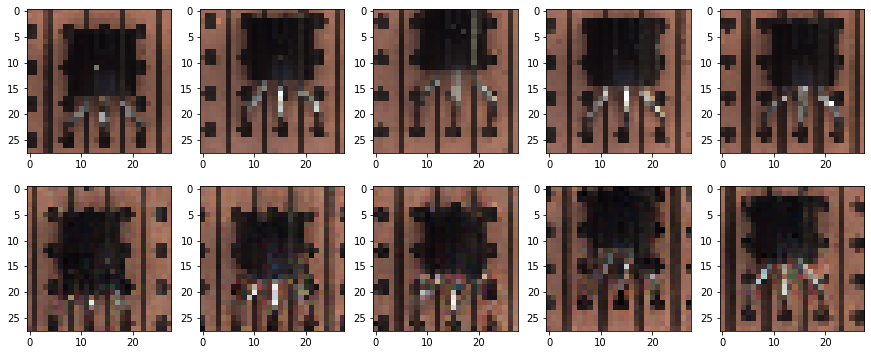

In [16]:
# 生成画像と訓練データを可視化する

def visualize():
    # 入力の乱数生成
    batch_size = 8
    z_dim = 20
    fixed_z = torch.randn(batch_size, z_dim)
    fake_images = G_update(fixed_z.to(device))

    # 訓練データ
    batch_iterator = iter(train_dataloader)  # イテレータに変換
    imges = next(batch_iterator)  # 1番目の要素を取り出す


    # 出力
    fig = plt.figure(figsize=(15, 6))
    for i in range(0, 5):
        # 上段に訓練データを
        plt.subplot(2, 5, i+1)
        plt.imshow(to_raw_image(imges[i].cpu().detach()))

        # 下段に生成データを表示する
        plt.subplot(2, 5, 5+i+1)
        plt.imshow(to_raw_image(fake_images[i].cpu().detach()))
        
visualize()

In [17]:
%%time
# 学習・検証を実行する x分ほどかかる

num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
Epoch 0/1500
epoch 0 || Epoch_D_Loss:0.0796 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0696
timer:  0.0968 sec.
Epoch 1/1500
epoch 1 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0665
timer:  0.0957 sec.
Epoch 2/1500
epoch 2 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0700 ||Epoch_E_Loss:0.0771
timer:  0.0959 sec.
Epoch 3/1500
epoch 3 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0796
timer:  0.0952 sec.
Epoch 4/1500
epoch 4 || Epoch_D_Loss:0.0596 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0825
timer:  0.0954 sec.
Epoch 5/1500
epoch 5 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0768 ||Epoch_E_Loss:0.0798
timer:  0.0957 sec.
Epoch 6/1500
epoch 6 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0733 ||Epoch_E_Loss:0.0889
timer:  0.0954 sec.
Epoch 7/1500
epoch 7 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0670 ||Epoch_E_Loss:0.0851
timer:  0.0954 sec.
Epoch 8/1500
epoch 8 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0676 ||Epoc

epoch 74 || Epoch_D_Loss:0.0648 ||Epoch_G_Loss:0.0690 ||Epoch_E_Loss:0.0811
timer:  0.0954 sec.
Epoch 75/1500
epoch 75 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0734
timer:  0.0950 sec.
Epoch 76/1500
epoch 76 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0830
timer:  0.0950 sec.
Epoch 77/1500
epoch 77 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0654 ||Epoch_E_Loss:0.0755
timer:  0.0956 sec.
Epoch 78/1500
epoch 78 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.0749 ||Epoch_E_Loss:0.0733
timer:  0.0952 sec.
Epoch 79/1500
epoch 79 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0793
timer:  0.0951 sec.
Epoch 80/1500
epoch 80 || Epoch_D_Loss:0.0747 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0752
timer:  0.0956 sec.
Epoch 81/1500
epoch 81 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0681
timer:  0.0952 sec.
Epoch 82/1500
epoch 82 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.0520 ||Epoch_E_Loss:0.0677
timer:  0.0951 sec.
Epoch 83/1500
epoch 83 |

epoch 149 || Epoch_D_Loss:0.0738 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0673
timer:  0.0955 sec.
Epoch 150/1500
epoch 150 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0689
timer:  0.0953 sec.
Epoch 151/1500
epoch 151 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0714
timer:  0.0952 sec.
Epoch 152/1500
epoch 152 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0728
timer:  0.0953 sec.
Epoch 153/1500
epoch 153 || Epoch_D_Loss:0.0833 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0680
timer:  0.0954 sec.
Epoch 154/1500
epoch 154 || Epoch_D_Loss:0.0818 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0748
timer:  0.0954 sec.
Epoch 155/1500
epoch 155 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0717
timer:  0.0956 sec.
Epoch 156/1500
epoch 156 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0678
timer:  0.0964 sec.
Epoch 157/1500
epoch 157 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0683
timer:  0.0954 sec.
Epoch 1

epoch 224 || Epoch_D_Loss:0.0841 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0606
timer:  0.0957 sec.
Epoch 225/1500
epoch 225 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0741
timer:  0.0950 sec.
Epoch 226/1500
epoch 226 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0834
timer:  0.0953 sec.
Epoch 227/1500
epoch 227 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0677 ||Epoch_E_Loss:0.0802
timer:  0.0954 sec.
Epoch 228/1500
epoch 228 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0734
timer:  0.0953 sec.
Epoch 229/1500
epoch 229 || Epoch_D_Loss:0.0792 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0723
timer:  0.0955 sec.
Epoch 230/1500
epoch 230 || Epoch_D_Loss:0.0868 ||Epoch_G_Loss:0.0657 ||Epoch_E_Loss:0.0601
timer:  0.0953 sec.
Epoch 231/1500
epoch 231 || Epoch_D_Loss:0.0840 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0624
timer:  0.0951 sec.
Epoch 232/1500
epoch 232 || Epoch_D_Loss:0.0785 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0647
timer:  0.0952 sec.
Epoch 2

epoch 299 || Epoch_D_Loss:0.0749 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0656
timer:  0.0954 sec.
Epoch 300/1500
epoch 300 || Epoch_D_Loss:0.0755 ||Epoch_G_Loss:0.0558 ||Epoch_E_Loss:0.0729
timer:  0.0952 sec.
Epoch 301/1500
epoch 301 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.0473 ||Epoch_E_Loss:0.0638
timer:  0.0956 sec.
Epoch 302/1500
epoch 302 || Epoch_D_Loss:0.0945 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0531
timer:  0.0956 sec.
Epoch 303/1500
epoch 303 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0603
timer:  0.0956 sec.
Epoch 304/1500
epoch 304 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0743
timer:  0.0951 sec.
Epoch 305/1500
epoch 305 || Epoch_D_Loss:0.0744 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0687
timer:  0.0953 sec.
Epoch 306/1500
epoch 306 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0706 ||Epoch_E_Loss:0.0641
timer:  0.0951 sec.
Epoch 307/1500
epoch 307 || Epoch_D_Loss:0.0724 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0724
timer:  0.0951 sec.
Epoch 3

epoch 374 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0773
timer:  0.0959 sec.
Epoch 375/1500
epoch 375 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0659
timer:  0.0954 sec.
Epoch 376/1500
epoch 376 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0704
timer:  0.0955 sec.
Epoch 377/1500
epoch 377 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0712
timer:  0.0956 sec.
Epoch 378/1500
epoch 378 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0639
timer:  0.0954 sec.
Epoch 379/1500
epoch 379 || Epoch_D_Loss:0.0946 ||Epoch_G_Loss:0.0524 ||Epoch_E_Loss:0.0535
timer:  0.0955 sec.
Epoch 380/1500
epoch 380 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.0434 ||Epoch_E_Loss:0.0606
timer:  0.0957 sec.
Epoch 381/1500
epoch 381 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0609
timer:  0.0953 sec.
Epoch 382/1500
epoch 382 || Epoch_D_Loss:0.0863 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0614
timer:  0.0953 sec.
Epoch 3

epoch 449 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0738 ||Epoch_E_Loss:0.0876
timer:  0.0957 sec.
Epoch 450/1500
epoch 450 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0936 ||Epoch_E_Loss:0.0864
timer:  0.0953 sec.
Epoch 451/1500
epoch 451 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0741 ||Epoch_E_Loss:0.0815
timer:  0.0954 sec.
Epoch 452/1500
epoch 452 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0778 ||Epoch_E_Loss:0.0743
timer:  0.0956 sec.
Epoch 453/1500
epoch 453 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0689 ||Epoch_E_Loss:0.0708
timer:  0.0951 sec.
Epoch 454/1500
epoch 454 || Epoch_D_Loss:0.0741 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0640
timer:  0.0951 sec.
Epoch 455/1500
epoch 455 || Epoch_D_Loss:0.0810 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0635
timer:  0.0953 sec.
Epoch 456/1500
epoch 456 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.0521 ||Epoch_E_Loss:0.0618
timer:  0.0952 sec.
Epoch 457/1500
epoch 457 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.0558 ||Epoch_E_Loss:0.0718
timer:  0.0953 sec.
Epoch 4

epoch 524 || Epoch_D_Loss:0.0746 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0730
timer:  0.0959 sec.
Epoch 525/1500
epoch 525 || Epoch_D_Loss:0.0734 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0700
timer:  0.0951 sec.
Epoch 526/1500
epoch 526 || Epoch_D_Loss:0.0882 ||Epoch_G_Loss:0.0725 ||Epoch_E_Loss:0.0572
timer:  0.0953 sec.
Epoch 527/1500
epoch 527 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.0477 ||Epoch_E_Loss:0.0741
timer:  0.0956 sec.
Epoch 528/1500
epoch 528 || Epoch_D_Loss:0.0838 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0592
timer:  0.0950 sec.
Epoch 529/1500
epoch 529 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0709
timer:  0.0951 sec.
Epoch 530/1500
epoch 530 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.0682 ||Epoch_E_Loss:0.0814
timer:  0.0955 sec.
Epoch 531/1500
epoch 531 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0659 ||Epoch_E_Loss:0.0769
timer:  0.0953 sec.
Epoch 532/1500
epoch 532 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.0737 ||Epoch_E_Loss:0.0707
timer:  0.0953 sec.
Epoch 5

epoch 599 || Epoch_D_Loss:0.0795 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0642
timer:  0.0965 sec.
Epoch 600/1500
epoch 600 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0665 ||Epoch_E_Loss:0.0645
timer:  0.0962 sec.
Epoch 601/1500
epoch 601 || Epoch_D_Loss:0.0783 ||Epoch_G_Loss:0.0521 ||Epoch_E_Loss:0.0708
timer:  0.0962 sec.
Epoch 602/1500
epoch 602 || Epoch_D_Loss:0.0778 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0725
timer:  0.0965 sec.
Epoch 603/1500
epoch 603 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0670
timer:  0.0962 sec.
Epoch 604/1500
epoch 604 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0652
timer:  0.0963 sec.
Epoch 605/1500
epoch 605 || Epoch_D_Loss:0.0698 ||Epoch_G_Loss:0.0800 ||Epoch_E_Loss:0.0677
timer:  0.0966 sec.
Epoch 606/1500
epoch 606 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.0755 ||Epoch_E_Loss:0.0764
timer:  0.0961 sec.
Epoch 607/1500
epoch 607 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0867
timer:  0.0962 sec.
Epoch 6

epoch 674 || Epoch_D_Loss:0.0878 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0582
timer:  0.0964 sec.
Epoch 675/1500
epoch 675 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0789
timer:  0.0960 sec.
Epoch 676/1500
epoch 676 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0885
timer:  0.0962 sec.
Epoch 677/1500
epoch 677 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0797
timer:  0.0963 sec.
Epoch 678/1500
epoch 678 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0705
timer:  0.0959 sec.
Epoch 679/1500
epoch 679 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0778
timer:  0.0968 sec.
Epoch 680/1500
epoch 680 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0710
timer:  0.0968 sec.
Epoch 681/1500
epoch 681 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0730
timer:  0.0963 sec.
Epoch 682/1500
epoch 682 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0647
timer:  0.0963 sec.
Epoch 6

epoch 749 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0572
timer:  0.0965 sec.
Epoch 750/1500
epoch 750 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0512 ||Epoch_E_Loss:0.0691
timer:  0.0961 sec.
Epoch 751/1500
epoch 751 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0660 ||Epoch_E_Loss:0.0658
timer:  0.0960 sec.
Epoch 752/1500
epoch 752 || Epoch_D_Loss:0.0703 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0708
timer:  0.0964 sec.
Epoch 753/1500
epoch 753 || Epoch_D_Loss:0.0674 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0727
timer:  0.0961 sec.
Epoch 754/1500
epoch 754 || Epoch_D_Loss:0.0664 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0770
timer:  0.0961 sec.
Epoch 755/1500
epoch 755 || Epoch_D_Loss:0.0707 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0686
timer:  0.0962 sec.
Epoch 756/1500
epoch 756 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0657
timer:  0.0961 sec.
Epoch 757/1500
epoch 757 || Epoch_D_Loss:0.0706 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0701
timer:  0.0962 sec.
Epoch 7

epoch 824 || Epoch_D_Loss:0.0565 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0906
timer:  0.0966 sec.
Epoch 825/1500
epoch 825 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0791
timer:  0.0962 sec.
Epoch 826/1500
epoch 826 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0701
timer:  0.0959 sec.
Epoch 827/1500
epoch 827 || Epoch_D_Loss:0.0810 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0654
timer:  0.0966 sec.
Epoch 828/1500
epoch 828 || Epoch_D_Loss:0.0832 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0685
timer:  0.0964 sec.
Epoch 829/1500
epoch 829 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0807
timer:  0.0962 sec.
Epoch 830/1500
epoch 830 || Epoch_D_Loss:0.0927 ||Epoch_G_Loss:0.0687 ||Epoch_E_Loss:0.0659
timer:  0.0965 sec.
Epoch 831/1500
epoch 831 || Epoch_D_Loss:0.0799 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0621
timer:  0.0966 sec.
Epoch 832/1500
epoch 832 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0470 ||Epoch_E_Loss:0.0697
timer:  0.0964 sec.
Epoch 8

epoch 899 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0558
timer:  0.0973 sec.
Epoch 900/1500
epoch 900 || Epoch_D_Loss:0.0736 ||Epoch_G_Loss:0.0622 ||Epoch_E_Loss:0.0711
timer:  0.0967 sec.
Epoch 901/1500
epoch 901 || Epoch_D_Loss:0.0702 ||Epoch_G_Loss:0.0527 ||Epoch_E_Loss:0.0718
timer:  0.0968 sec.
Epoch 902/1500
epoch 902 || Epoch_D_Loss:0.0801 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0696
timer:  0.0969 sec.
Epoch 903/1500
epoch 903 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0791 ||Epoch_E_Loss:0.0807
timer:  0.0968 sec.
Epoch 904/1500
epoch 904 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0823 ||Epoch_E_Loss:0.0773
timer:  0.0968 sec.
Epoch 905/1500
epoch 905 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0795
timer:  0.0972 sec.
Epoch 906/1500
epoch 906 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0626 ||Epoch_E_Loss:0.0920
timer:  0.0969 sec.
Epoch 907/1500
epoch 907 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0567 ||Epoch_E_Loss:0.0816
timer:  0.0967 sec.
Epoch 9

epoch 974 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.0723 ||Epoch_E_Loss:0.0694
timer:  0.0970 sec.
Epoch 975/1500
epoch 975 || Epoch_D_Loss:0.0678 ||Epoch_G_Loss:0.0643 ||Epoch_E_Loss:0.0749
timer:  0.0966 sec.
Epoch 976/1500
epoch 976 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0778
timer:  0.0965 sec.
Epoch 977/1500
epoch 977 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0733
timer:  0.0970 sec.
Epoch 978/1500
epoch 978 || Epoch_D_Loss:0.0691 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0732
timer:  0.0967 sec.
Epoch 979/1500
epoch 979 || Epoch_D_Loss:0.0722 ||Epoch_G_Loss:0.0486 ||Epoch_E_Loss:0.0692
timer:  0.0967 sec.
Epoch 980/1500
epoch 980 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.0686 ||Epoch_E_Loss:0.0661
timer:  0.0971 sec.
Epoch 981/1500
epoch 981 || Epoch_D_Loss:0.0805 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0633
timer:  0.0966 sec.
Epoch 982/1500
epoch 982 || Epoch_D_Loss:0.0790 ||Epoch_G_Loss:0.0538 ||Epoch_E_Loss:0.0683
timer:  0.0969 sec.
Epoch 9

epoch 1049 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0641 ||Epoch_E_Loss:0.0719
timer:  0.0973 sec.
Epoch 1050/1500
epoch 1050 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0737
timer:  0.0966 sec.
Epoch 1051/1500
epoch 1051 || Epoch_D_Loss:0.0731 ||Epoch_G_Loss:0.0663 ||Epoch_E_Loss:0.0682
timer:  0.0969 sec.
Epoch 1052/1500
epoch 1052 || Epoch_D_Loss:0.0683 ||Epoch_G_Loss:0.0638 ||Epoch_E_Loss:0.0696
timer:  0.0971 sec.
Epoch 1053/1500
epoch 1053 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.0699 ||Epoch_E_Loss:0.0667
timer:  0.0967 sec.
Epoch 1054/1500
epoch 1054 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0667
timer:  0.0968 sec.
Epoch 1055/1500
epoch 1055 || Epoch_D_Loss:0.0843 ||Epoch_G_Loss:0.0614 ||Epoch_E_Loss:0.0692
timer:  0.0970 sec.
Epoch 1056/1500
epoch 1056 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.0707
timer:  0.0969 sec.
Epoch 1057/1500
epoch 1057 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0739
timer:  0.

epoch 1121 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0737
timer:  0.0971 sec.
Epoch 1122/1500
epoch 1122 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0651 ||Epoch_E_Loss:0.0770
timer:  0.0967 sec.
Epoch 1123/1500
epoch 1123 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0633 ||Epoch_E_Loss:0.0820
timer:  0.0966 sec.
Epoch 1124/1500
epoch 1124 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0697 ||Epoch_E_Loss:0.0784
timer:  0.0974 sec.
Epoch 1125/1500
epoch 1125 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.0719
timer:  0.0965 sec.
Epoch 1126/1500
epoch 1126 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0870
timer:  0.0969 sec.
Epoch 1127/1500
epoch 1127 || Epoch_D_Loss:0.0704 ||Epoch_G_Loss:0.0705 ||Epoch_E_Loss:0.0708
timer:  0.0969 sec.
Epoch 1128/1500
epoch 1128 || Epoch_D_Loss:0.0598 ||Epoch_G_Loss:0.0630 ||Epoch_E_Loss:0.0790
timer:  0.0971 sec.
Epoch 1129/1500
epoch 1129 || Epoch_D_Loss:0.0722 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0677
timer:  0.

epoch 1193 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.0490 ||Epoch_E_Loss:0.0657
timer:  0.0973 sec.
Epoch 1194/1500
epoch 1194 || Epoch_D_Loss:0.0895 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0537
timer:  0.0967 sec.
Epoch 1195/1500
epoch 1195 || Epoch_D_Loss:0.0807 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0624
timer:  0.0969 sec.
Epoch 1196/1500
epoch 1196 || Epoch_D_Loss:0.0821 ||Epoch_G_Loss:0.0667 ||Epoch_E_Loss:0.0596
timer:  0.0974 sec.
Epoch 1197/1500
epoch 1197 || Epoch_D_Loss:0.0812 ||Epoch_G_Loss:0.0656 ||Epoch_E_Loss:0.0708
timer:  0.0967 sec.
Epoch 1198/1500
epoch 1198 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0941 ||Epoch_E_Loss:0.0711
timer:  0.0993 sec.
Epoch 1199/1500
epoch 1199 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0701 ||Epoch_E_Loss:0.0879
timer:  0.0971 sec.
Epoch 1200/1500
epoch 1200 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0770 ||Epoch_E_Loss:0.0793
timer:  0.0968 sec.
Epoch 1201/1500
epoch 1201 || Epoch_D_Loss:0.0663 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0714
timer:  0.

epoch 1265 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0663
timer:  0.0957 sec.
Epoch 1266/1500
epoch 1266 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0714
timer:  0.0955 sec.
Epoch 1267/1500
epoch 1267 || Epoch_D_Loss:0.0679 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0771
timer:  0.0952 sec.
Epoch 1268/1500
epoch 1268 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0668
timer:  0.0956 sec.
Epoch 1269/1500
epoch 1269 || Epoch_D_Loss:0.0772 ||Epoch_G_Loss:0.0779 ||Epoch_E_Loss:0.0633
timer:  0.0954 sec.
Epoch 1270/1500
epoch 1270 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0792
timer:  0.0955 sec.
Epoch 1271/1500
epoch 1271 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.0681 ||Epoch_E_Loss:0.0759
timer:  0.0956 sec.
Epoch 1272/1500
epoch 1272 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0838
timer:  0.0952 sec.
Epoch 1273/1500
epoch 1273 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0696 ||Epoch_E_Loss:0.0715
timer:  0.

epoch 1337 || Epoch_D_Loss:0.0653 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0774
timer:  0.0958 sec.
Epoch 1338/1500
epoch 1338 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0666 ||Epoch_E_Loss:0.0761
timer:  0.0952 sec.
Epoch 1339/1500
epoch 1339 || Epoch_D_Loss:0.0681 ||Epoch_G_Loss:0.0631 ||Epoch_E_Loss:0.0745
timer:  0.0952 sec.
Epoch 1340/1500
epoch 1340 || Epoch_D_Loss:0.0662 ||Epoch_G_Loss:0.0649 ||Epoch_E_Loss:0.0742
timer:  0.0957 sec.
Epoch 1341/1500
epoch 1341 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0644
timer:  0.0954 sec.
Epoch 1342/1500
epoch 1342 || Epoch_D_Loss:0.0751 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0698
timer:  0.0953 sec.
Epoch 1343/1500
epoch 1343 || Epoch_D_Loss:0.0765 ||Epoch_G_Loss:0.0523 ||Epoch_E_Loss:0.0697
timer:  0.0960 sec.
Epoch 1344/1500
epoch 1344 || Epoch_D_Loss:0.0801 ||Epoch_G_Loss:0.0547 ||Epoch_E_Loss:0.0596
timer:  0.0953 sec.
Epoch 1345/1500
epoch 1345 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.0640 ||Epoch_E_Loss:0.0676
timer:  0.

epoch 1409 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0713
timer:  0.0957 sec.
Epoch 1410/1500
epoch 1410 || Epoch_D_Loss:0.0781 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0736
timer:  0.0955 sec.
Epoch 1411/1500
epoch 1411 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0755
timer:  0.0952 sec.
Epoch 1412/1500
epoch 1412 || Epoch_D_Loss:0.0812 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0692
timer:  0.0958 sec.
Epoch 1413/1500
epoch 1413 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.0491 ||Epoch_E_Loss:0.0724
timer:  0.0956 sec.
Epoch 1414/1500
epoch 1414 || Epoch_D_Loss:0.0817 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0667
timer:  0.0953 sec.
Epoch 1415/1500
epoch 1415 || Epoch_D_Loss:0.0718 ||Epoch_G_Loss:0.0512 ||Epoch_E_Loss:0.0771
timer:  0.0955 sec.
Epoch 1416/1500
epoch 1416 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.0707 ||Epoch_E_Loss:0.0731
timer:  0.0953 sec.
Epoch 1417/1500
epoch 1417 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0896
timer:  0.

epoch 1481 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0847
timer:  0.0958 sec.
Epoch 1482/1500
epoch 1482 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.0704 ||Epoch_E_Loss:0.0653
timer:  0.0953 sec.
Epoch 1483/1500
epoch 1483 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0766
timer:  0.0954 sec.
Epoch 1484/1500
epoch 1484 || Epoch_D_Loss:0.0779 ||Epoch_G_Loss:0.0691 ||Epoch_E_Loss:0.0633
timer:  0.0958 sec.
Epoch 1485/1500
epoch 1485 || Epoch_D_Loss:0.0727 ||Epoch_G_Loss:0.0613 ||Epoch_E_Loss:0.0680
timer:  0.0952 sec.
Epoch 1486/1500
epoch 1486 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0758
timer:  0.0952 sec.
Epoch 1487/1500
epoch 1487 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0688
timer:  0.0959 sec.
Epoch 1488/1500
epoch 1488 || Epoch_D_Loss:0.0700 ||Epoch_G_Loss:0.0635 ||Epoch_E_Loss:0.0699
timer:  0.0952 sec.
Epoch 1489/1500
epoch 1489 || Epoch_D_Loss:0.0690 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0736
timer:  0.

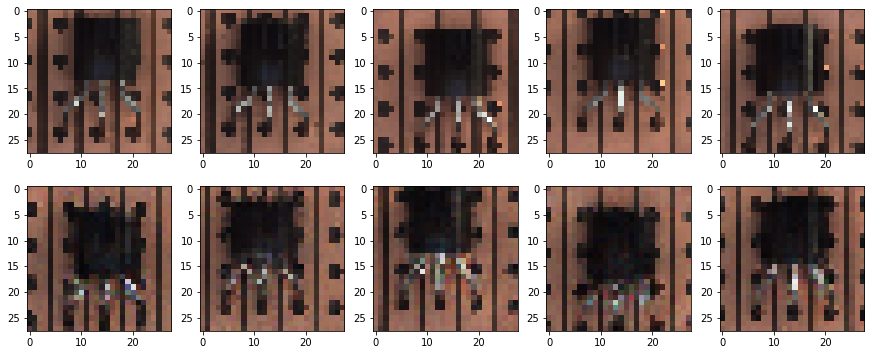

In [18]:
visualize()

# テスト画像で異常検知する

In [19]:
# テスト用のDataLoaderの作成

def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    # 画像ファイルパスを格納
    train_img_list = sorted(DATA_ROOT.glob(f'test/*/*{SUFFIX}'))

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

prep.prepare_test(test_img_list,
                  skip_file_creation=True
                 )

# Datasetを作成
test_dataset = GAN_Img_Dataset(file_list=prep.test_files, load_size=SIZE + 4, crop_size=SIZE,
                               transform=ImageTransform(), random=False, #debug='test_ds'
                              )

# DataLoaderを作成
batch_size = 100

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
test_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[prep.test_files[i] for i in test_list]

['tmp/effgan-mvtrans/test/bent_lead-000.png',
 'tmp/effgan-mvtrans/test/cut_lead-000.png',
 'tmp/effgan-mvtrans/test/damaged_case-000.png',
 'tmp/effgan-mvtrans/test/good-000.png',
 'tmp/effgan-mvtrans/test/good-010.png',
 'tmp/effgan-mvtrans/test/good-020.png',
 'tmp/effgan-mvtrans/test/good-030.png',
 'tmp/effgan-mvtrans/test/good-040.png',
 'tmp/effgan-mvtrans/test/good-050.png',
 'tmp/effgan-mvtrans/test/misplaced-000.png']

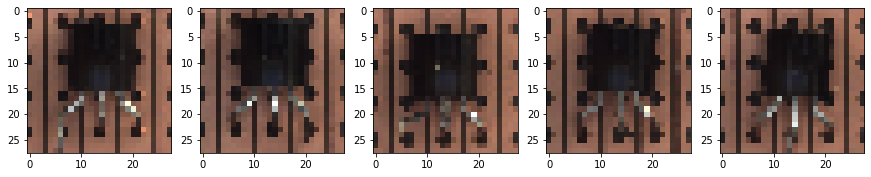

In [21]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(to_raw_image(imges[i].cpu().detach()))

In [28]:
imges.mean(1).shape

torch.Size([100, 28, 28])

In [29]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    print(x.shape, fake_img.shape, z_out_real.shape)

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    # dl .mean(1) により、チャンネル間で平均を取り白黒化している
    residual_loss = torch.abs(x.mean(1)-fake_img.mean(1))
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

torch.Size([10, 3, 28, 28]) torch.Size([10, 3, 28, 28]) torch.Size([10, 20])
total loss： [192.  94. 217.  98. 212. 155. 140. 174. 198. 245.]
0
10
20
30
40


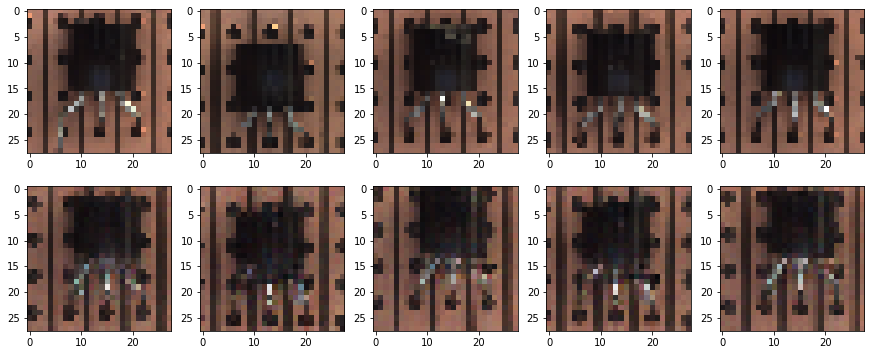

In [30]:
# 教師データの画像をエンコードしてzにしてから、Gで生成
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    imges[test_list].to(device), imges_reconstract[test_list], z_out_real[test_list],
    D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    img_idx = test_list[i]
    print(img_idx)
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(to_raw_image(imges[img_idx].cpu().detach()))

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(to_raw_image(imges_reconstract[img_idx].cpu().detach()))

以上